<a href="https://colab.research.google.com/github/teobras/My_Script-Articles/blob/main/Article_1-new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instalar Bibliotecas

In [1]:
# ===============================
# INSTALAR DE BIBLIOTECAS
# ===============================
%%capture
!pip install arch
!pip install termcolor
!pip install pmdarima
!pip install darts
!pip install optuna
!pip install xlsxwriter

# ===============================
# IMPORTAÇÃO DE BIBLIOTECAS
# ===============================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
import pmdarima as pm

import statsmodels.api as sm
from arch import arch_model

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from darts import TimeSeries

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# 2. Carregar Dados

In [2]:
# ======================================================
# 1. Montar Google Drive no Colab
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

# ======================================================
# 2. Importar bibliotecas necessárias
# ======================================================
import pandas as pd

# ======================================================
# 3. Definir caminhos dos ficheiros na Google Drive
#    (ajusta a pasta conforme onde guardaste)
# ======================================================

# Exemplo: ficheiros estão na pasta principal "My Drive"
path_cambio = '/content/drive/MyDrive/Colab_Notebooks/Datasets/cambio.csv'
path_inflacao = '/content/drive/MyDrive/Colab_Notebooks/Datasets/inflacao.csv'
path_petroleo='//content/drive/MyDrive/Colab_Notebooks/Datasets/petroleo.csv'

# Se forem ficheiros Excel:
# path_inflacao = '/content/drive/My Drive/INFL_BNA.xlsx'
# path_pib = '/content/drive/My Drive/PIB_BNA.xlsx'

# ======================================================
# 4. Carregar os datasets (CSV ou Excel)
# ======================================================

# Para CSV:
cambio = pd.read_csv(path_cambio)
inflacao = pd.read_csv(path_inflacao)
petroleo = pd.read_csv(path_petroleo)


# Para Excel (se for o caso):
# inflacao = pd.read_excel(path_inflacao)
# pib = pd.read_excel(path_pib)

# ======================================================
# 5. Ver 5 primeiras linhas
# ======================================================
print("\n Dados do Cambio:")
display(cambio.head())

print("\n Dados da Inflação:")
display(inflacao.head())

print("\n Dados do Petroleo:")
display(petroleo.head())

# ======================================================
# 6. Converter coluna Date para formato datetime
# ======================================================
cambio['date'] = pd.to_datetime(cambio['date'])
inflacao['date'] = pd.to_datetime(inflacao['date'])
petroleo['date'] = pd.to_datetime(petroleo['date'])

# ======================================================
# 7. Ordenar por data (opcional mas recomendado)
# ======================================================
cambio = cambio.sort_values('date')
inflacao = inflacao.sort_values('date')
petroleo = petroleo.sort_values('date')

# ======================================================
# 8. Mostrar informação geral
# ======================================================
print("\n Info Cambio:")
print(cambio.info())
print("\n Info Inflação:")
print(inflacao.info())

print("\n Petroleo:")
print(petroleo.info())

Mounted at /content/drive

 Dados do Cambio:


,date,cambio
0,2020-12-04,-0.340
1,2020-12-07,-0.368
2,2020-12-08,-0.393
3,2020-12-09,-0.384
4,2020-12-10,-0.399



 Dados da Inflação:


,date,inflacao
0,2020-12-07,1.88
1,2020-12-08,1.89
2,2020-12-09,1.91
3,2020-12-10,1.88
4,2020-12-11,1.87



 Dados do Petroleo:


,date,petroleo
0,2020-12-01,47.03
1,2020-12-02,47.80
2,2020-12-03,48.37
3,2020-12-04,49.10
4,2020-12-07,48.63



 Info Cambio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1305 non-null   datetime64[ns]
 1   cambio  1249 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB
None

 Info Inflação:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1305 non-null   datetime64[ns]
 1   inflacao  1250 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB
None

 Petroleo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1305 non-null   datetime64[ns]
 1   petro

# 3. Limpeza e Preparação de Dados

In [3]:
# -------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --------------------------------------------
# 2. LIMPAR OS NOMES DAS COLUNAS
# -------------------------------------------
cambio.columns   = cambio.columns.str.strip()
inflacao.columns = inflacao.columns.str.strip()
petroleo.columns = petroleo.columns.str.strip()

# Identificar colunas de datas automaticamente
possiveis_datas = ['Date', 'DATA', 'Data', 'date', 'Periodo', 'periodo']

# Resetar o índice se a coluna de data já for o índice
if cambio.index.name in possiveis_datas:
    cambio = cambio.reset_index()
if inflacao.index.name in possiveis_datas:
    inflacao = inflacao.reset_index()
if petroleo.index.name in possiveis_datas:
    petroleo = petroleo.reset_index()

col_data_cambio   = [c for c in cambio.columns if c in possiveis_datas][0]
col_data_inflacao = [c for c in inflacao.columns if c in possiveis_datas][0]
col_data_petroleo = [c for c in petroleo.columns if c in possiveis_datas][0]

# Converter para datetime
cambio[col_data_cambio]       = pd.to_datetime(cambio[col_data_cambio])
inflacao[col_data_inflacao]   = pd.to_datetime(inflacao[col_data_inflacao])
petroleo[col_data_petroleo]   = pd.to_datetime(petroleo[col_data_petroleo])

# Ordenar
cambio    = cambio.sort_values(col_data_cambio)
inflacao  = inflacao.sort_values(col_data_inflacao)
petroleo  = petroleo.sort_values(col_data_petroleo)

# -------------------------------------------
# 3. REMOVER MISSING VALUES
# -------------------------------------------
cambio   = cambio.dropna()
inflacao = inflacao.dropna()
petroleo = petroleo.dropna()

print("Após remoção de missing:")
print(cambio.isna().sum())
print(inflacao.isna().sum())
print(petroleo.isna().sum())

# -------------------------------------------
# 4. AJUSTES / CRIAR LOG-TRANSFORMATION
# -------------------------------------------
# Criar colunas log (somente se valores > 0)

# Câmbio
if (cambio.iloc[:,1] > 0).all():
    cambio["log_cambio"] = np.log(cambio.iloc[:,1])
else:
    print("⚠ Câmbio contém valores <= 0 — log não aplicado.")

# Inflação
if (inflacao.iloc[:,1] > 0).all():
    inflacao["log_inflacao"] = np.log(inflacao.iloc[:,1])
else:
    print("⚠ Inflação contém valores <= 0 — log não aplicado.")

# Petróleo
if (petroleo.iloc[:,1] > 0).all():
    petroleo["log_petroleo"] = np.log(petroleo.iloc[:,1])
else:
    print("⚠ Petróleo contém valores <= 0 — log não aplicado.")

# -------------------------------------------
# 5. UNIFICAR FREQUÊNCIA TEMPORAL (mensal)
# -------------------------------------------
cambio    = cambio.set_index(col_data_cambio).resample("M").mean()
inflacao  = inflacao.set_index(col_data_inflacao).resample("M").mean()
petroleo  = petroleo.set_index(col_data_petroleo).resample("M").mean()

# Interpolar valores faltantes
cambio    = cambio.interpolate()
inflacao  = inflacao.interpolate()
petroleo  = petroleo.interpolate()

# -------------------------------------------
# 6. JUNTAR NUM ÚNICO DATAFRAME
# -------------------------------------------
df = cambio.merge(inflacao, left_index=True, right_index=True, how="inner")\
           .merge(petroleo, left_index=True, right_index=True, how="inner")

# Renomear colunas
# A lista de colunas precisa corresponder ao número de colunas no df.
# Como 'log_cambio' não foi criado, removemos ele da lista de renomeação.
df.columns = ["Cambio", "Inflacao", "log_inflacao", "Petroleo", "log_petroleo"]

# -------------------------------------------
# 7. NORMALIZAÇÃO
# -------------------------------------------
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

print("\n LIMPEZA E PREPARAÇÃO CONCLUÍDA!")
print(df_scaled.head())

Após remoção de missing:
date      0
cambio    0
dtype: int64
date        0
inflacao    0
dtype: int64
date        0
petroleo    0
dtype: int64
⚠ Câmbio contém valores <= 0 — log não aplicado.

 LIMPEZA E PREPARAÇÃO CONCLUÍDA!
              Cambio  Inflacao  log_inflacao  Petroleo  log_petroleo
date                                                                
2020-12-31  0.020635  0.000000      0.000000  0.000000      0.000000
2021-01-31  0.028369  0.158888      0.188455  0.065739      0.101794
2021-02-28  0.075627  0.262055      0.303436  0.168912      0.243796
2021-03-31  0.154985  0.361863      0.409391  0.212004      0.298817
2021-04-30  0.143793  0.439775      0.490019  0.203705      0.288910


# 4. Análise Exploratória de Dados

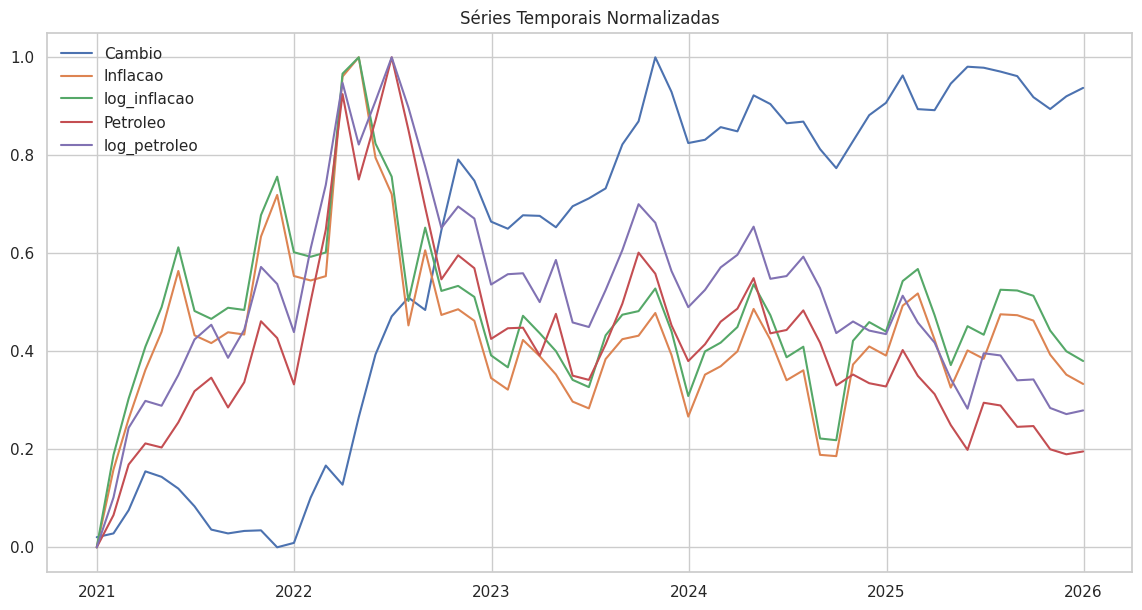


### DECOMPOSIÇÃO DA SÉRIE — Cambio ###


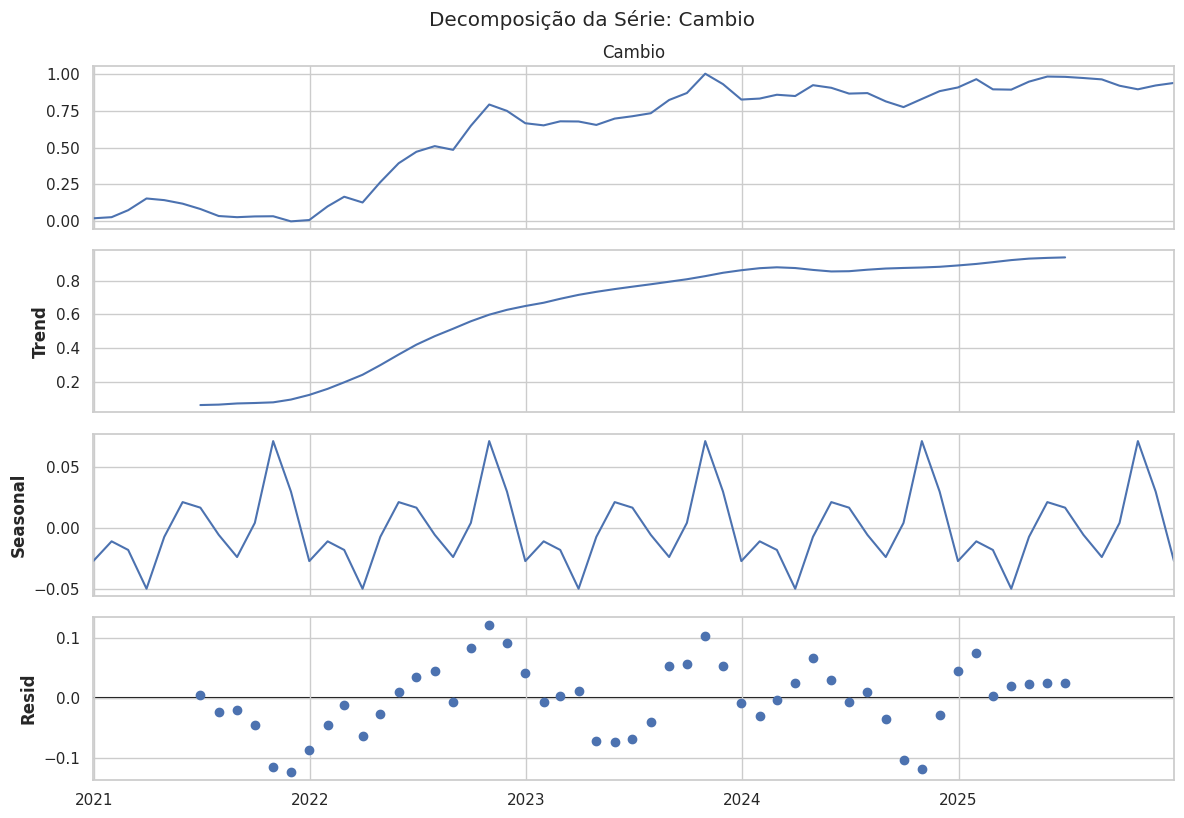


### DECOMPOSIÇÃO DA SÉRIE — Inflacao ###


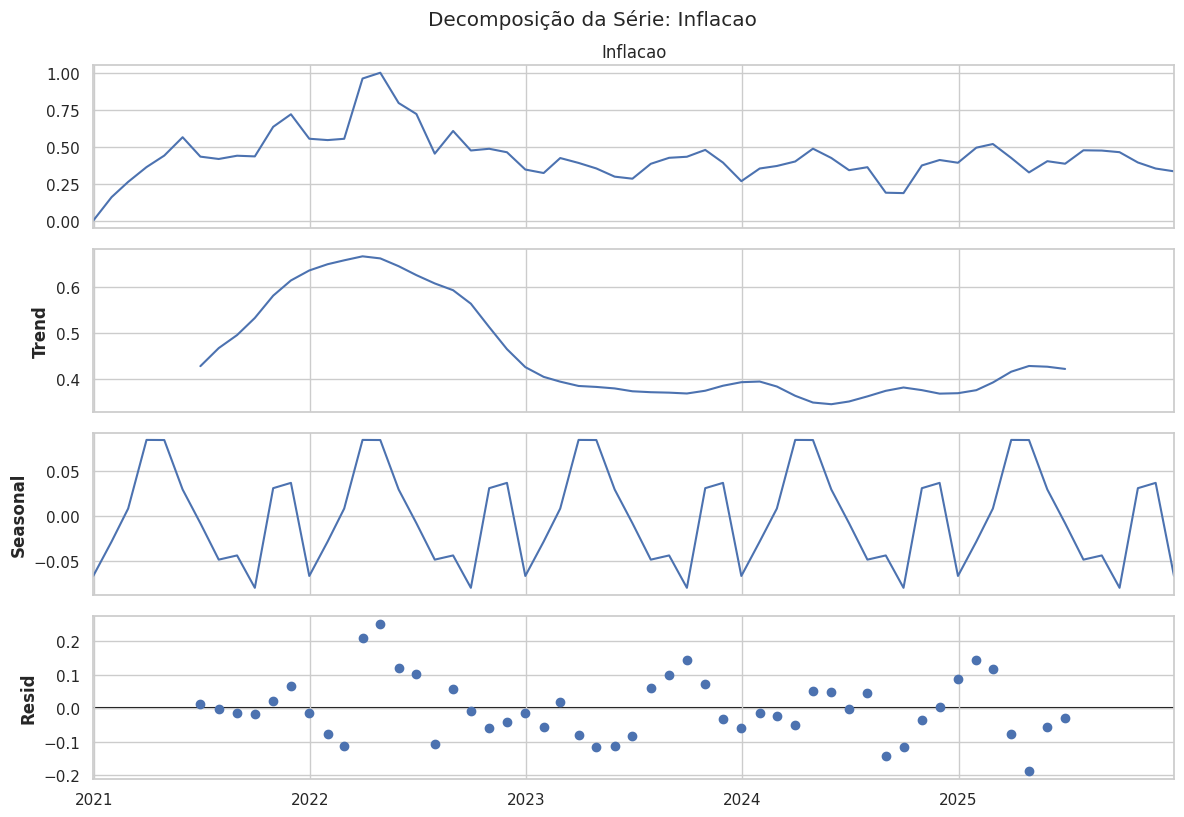


### DECOMPOSIÇÃO DA SÉRIE — log_inflacao ###


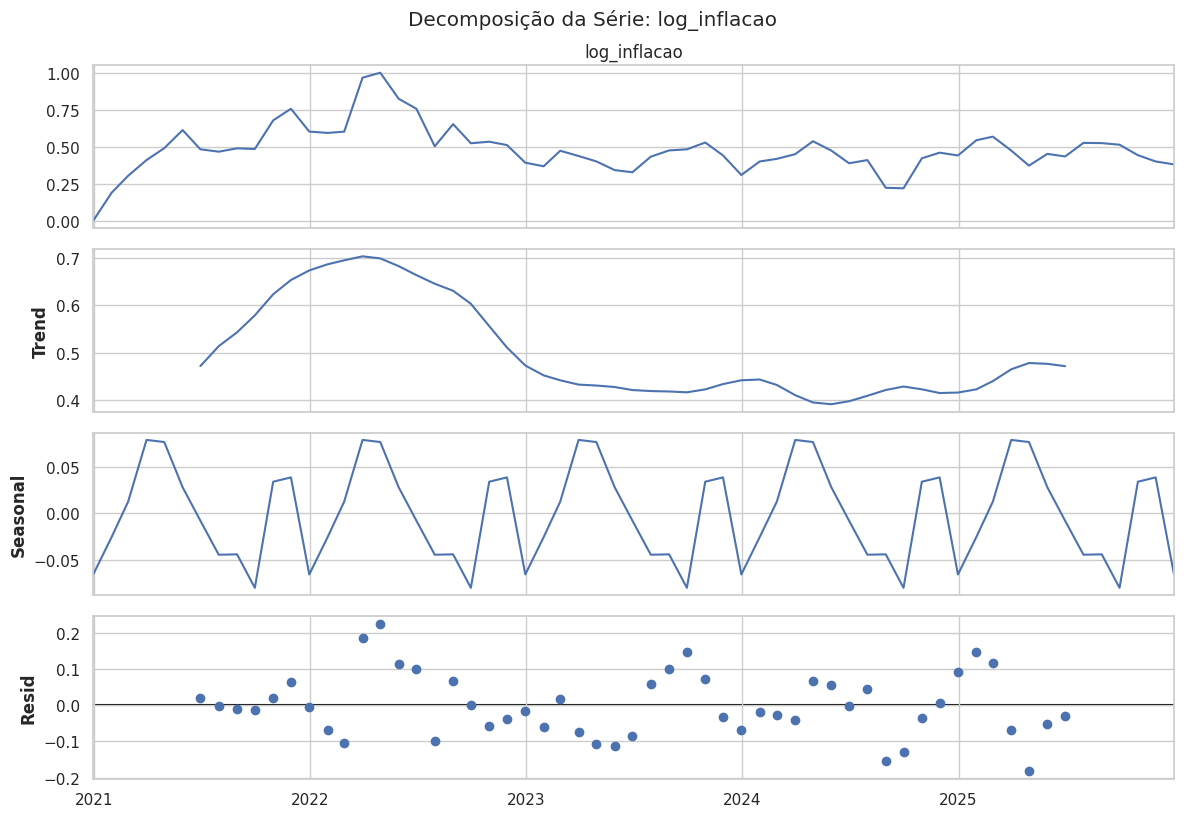


### DECOMPOSIÇÃO DA SÉRIE — Petroleo ###


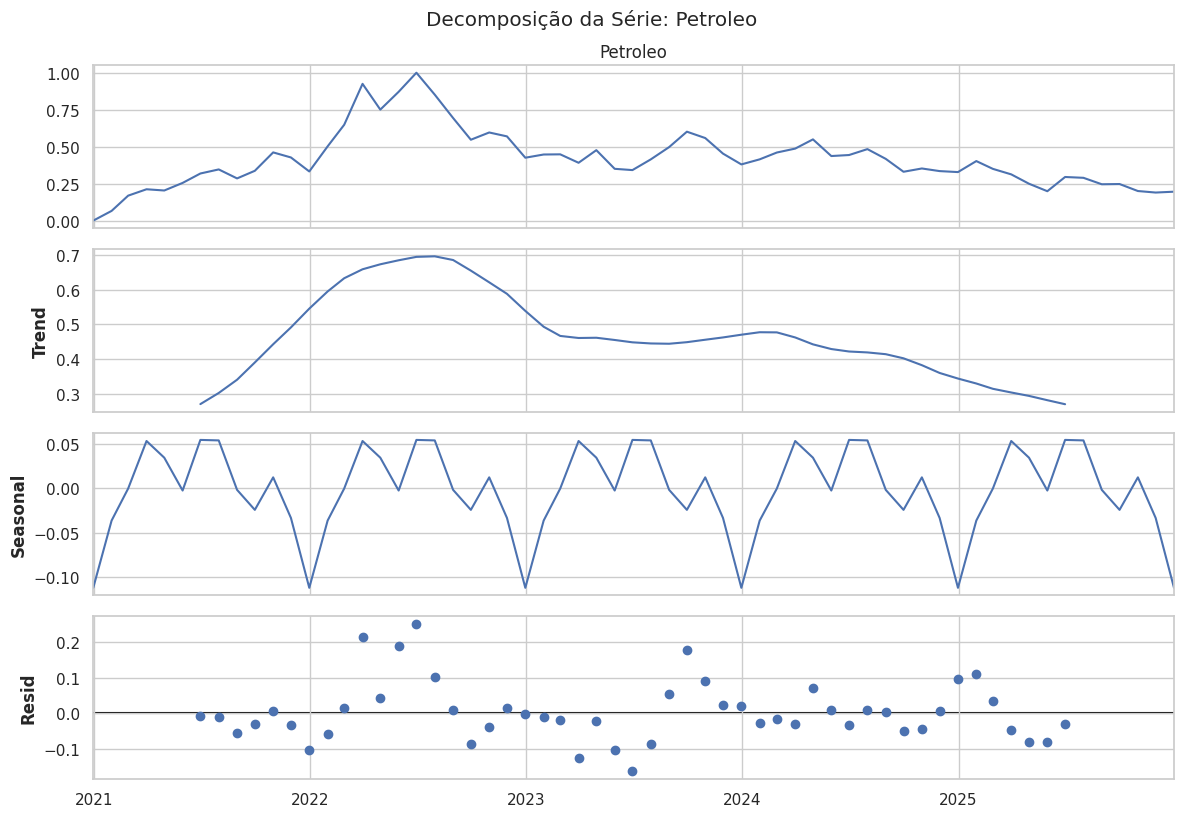


### DECOMPOSIÇÃO DA SÉRIE — log_petroleo ###


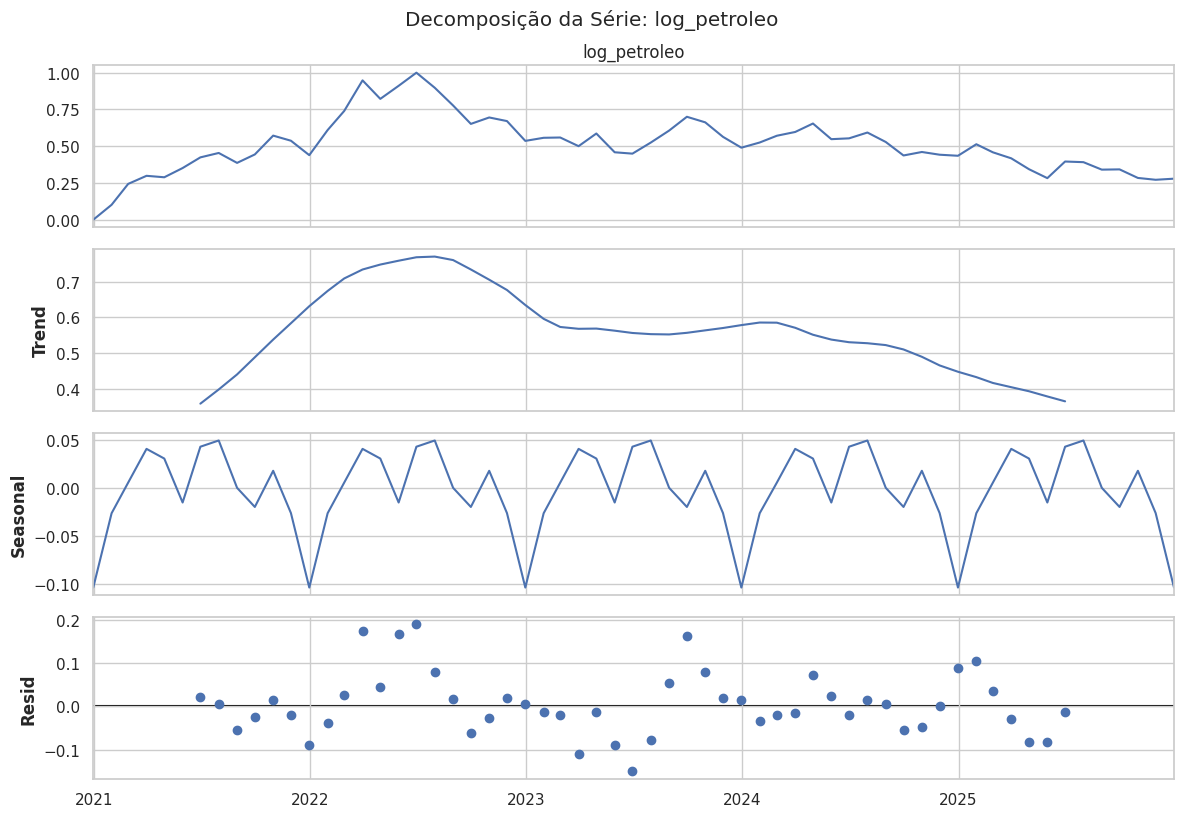

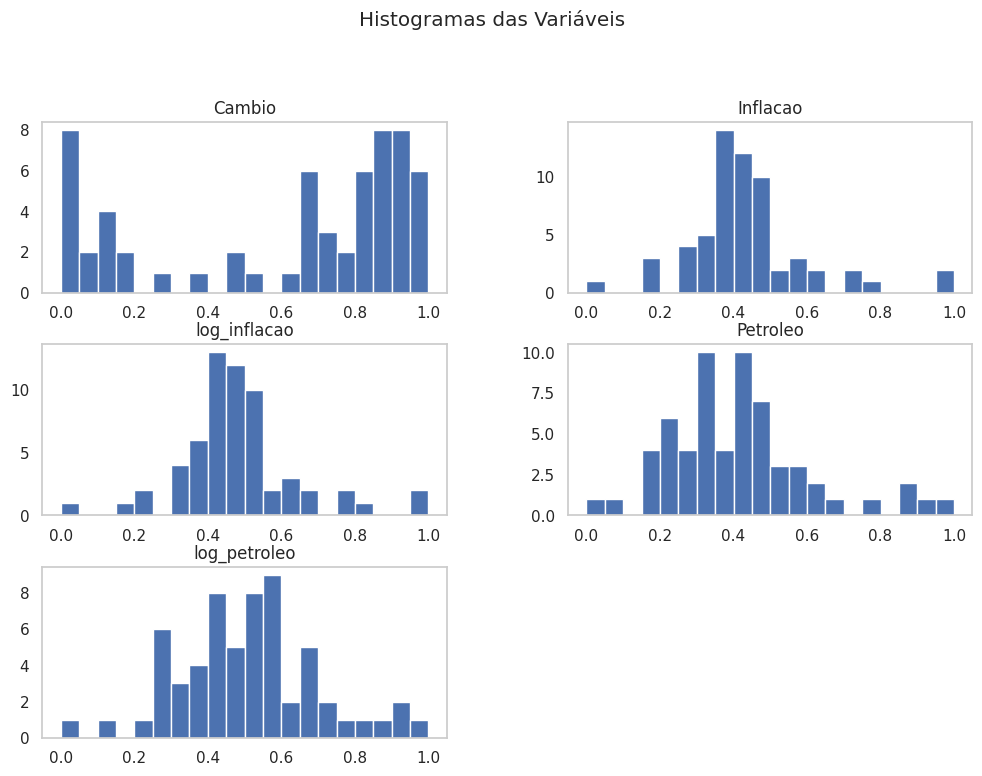

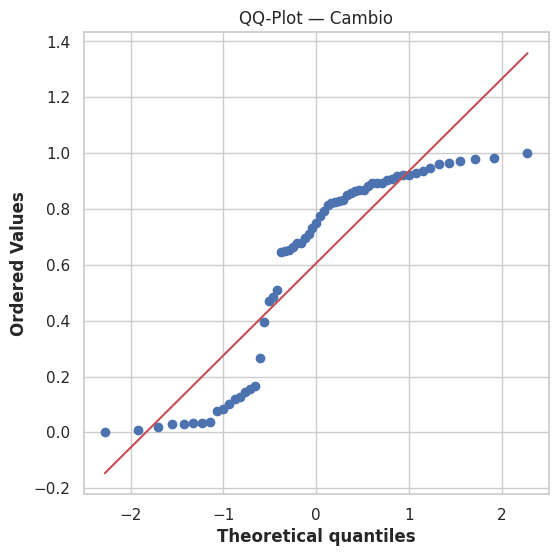

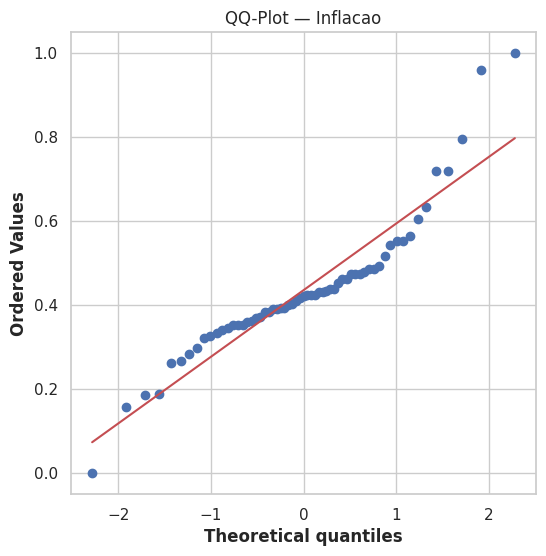

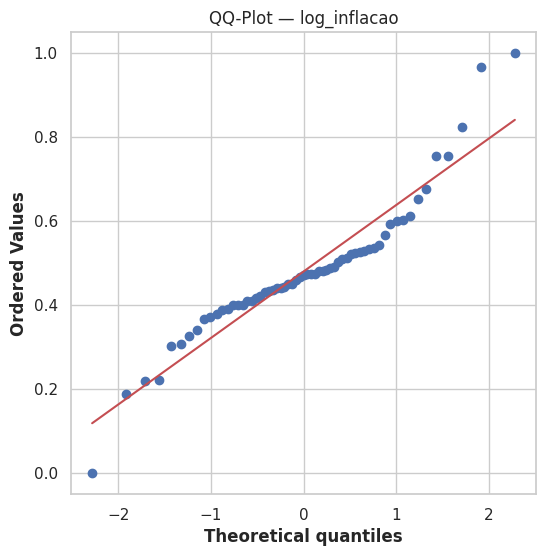

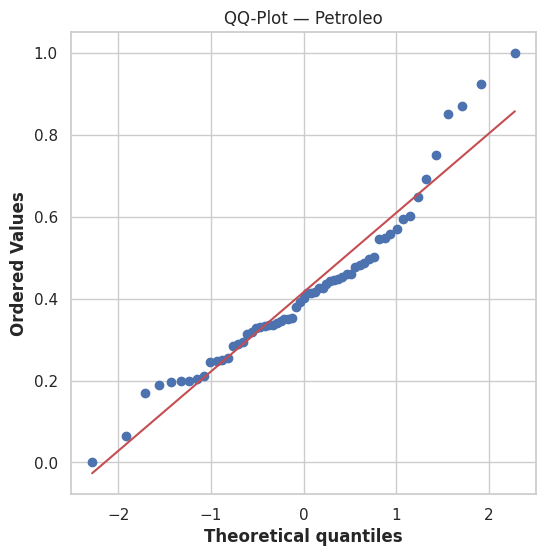

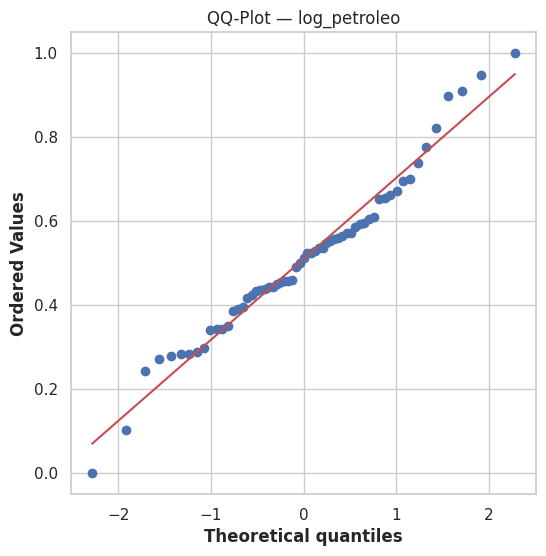

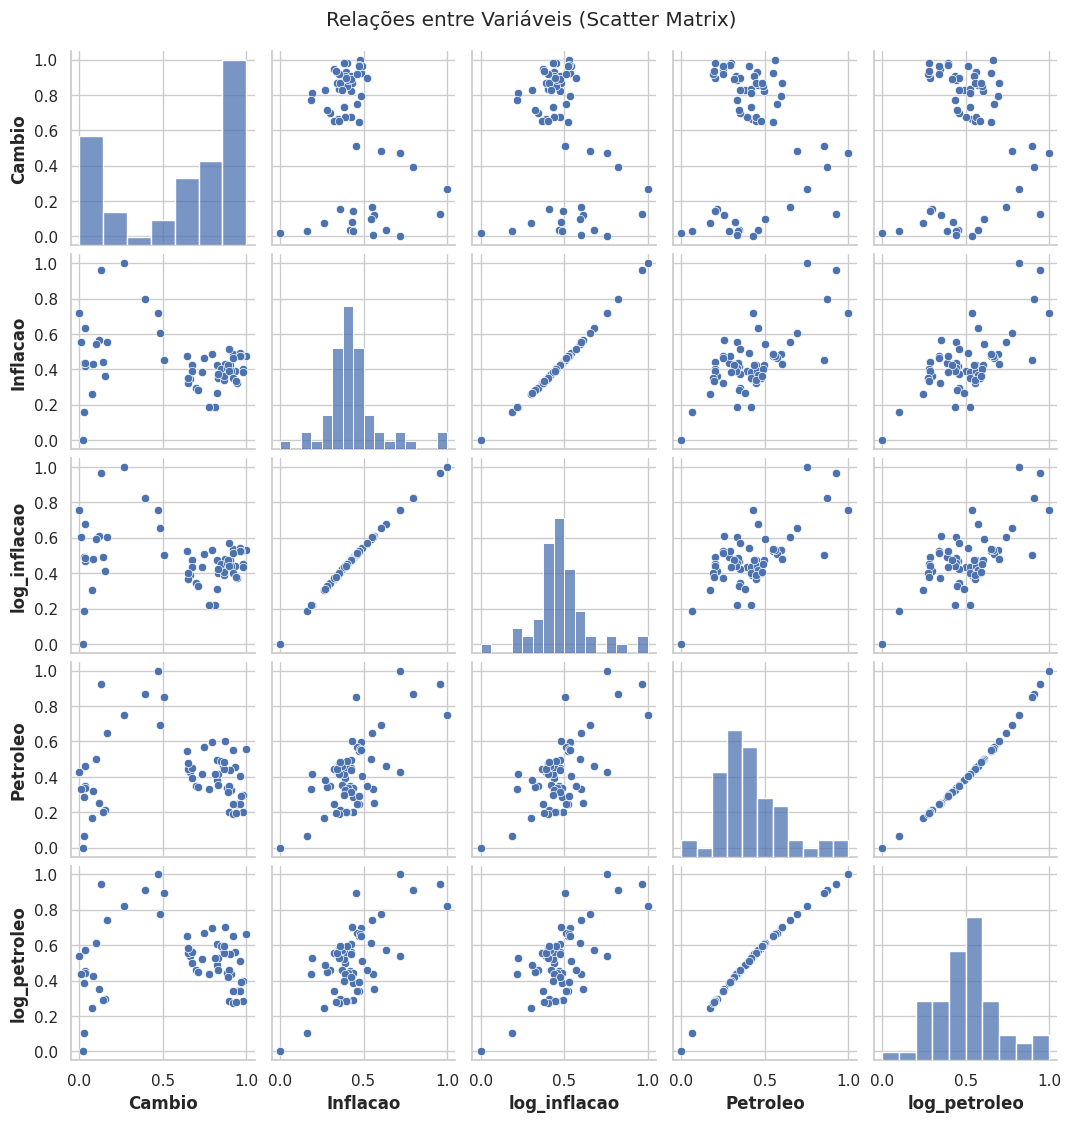

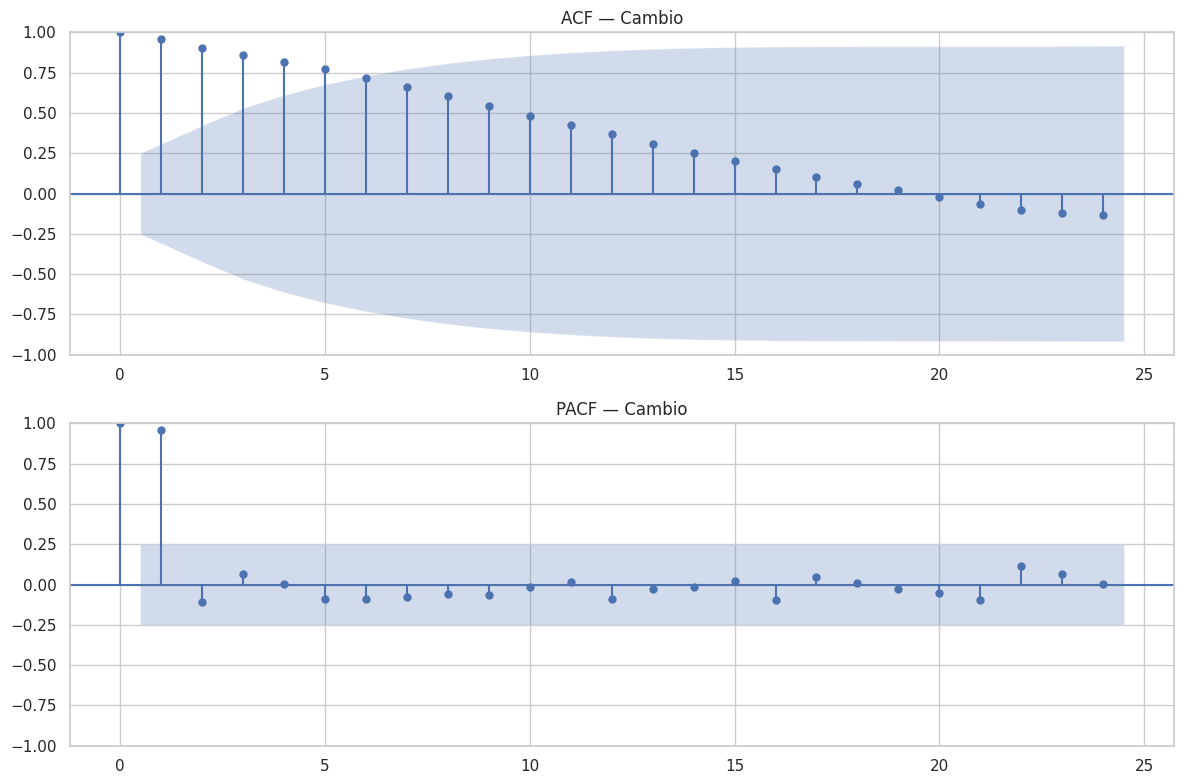

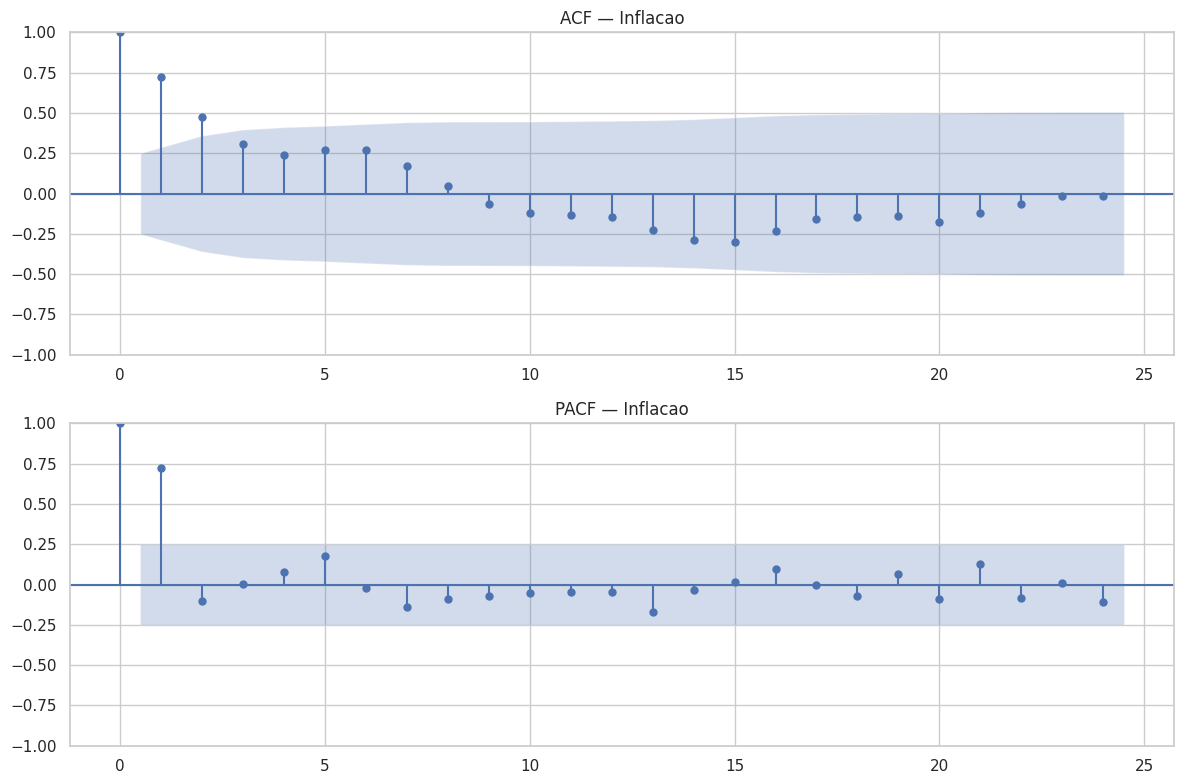

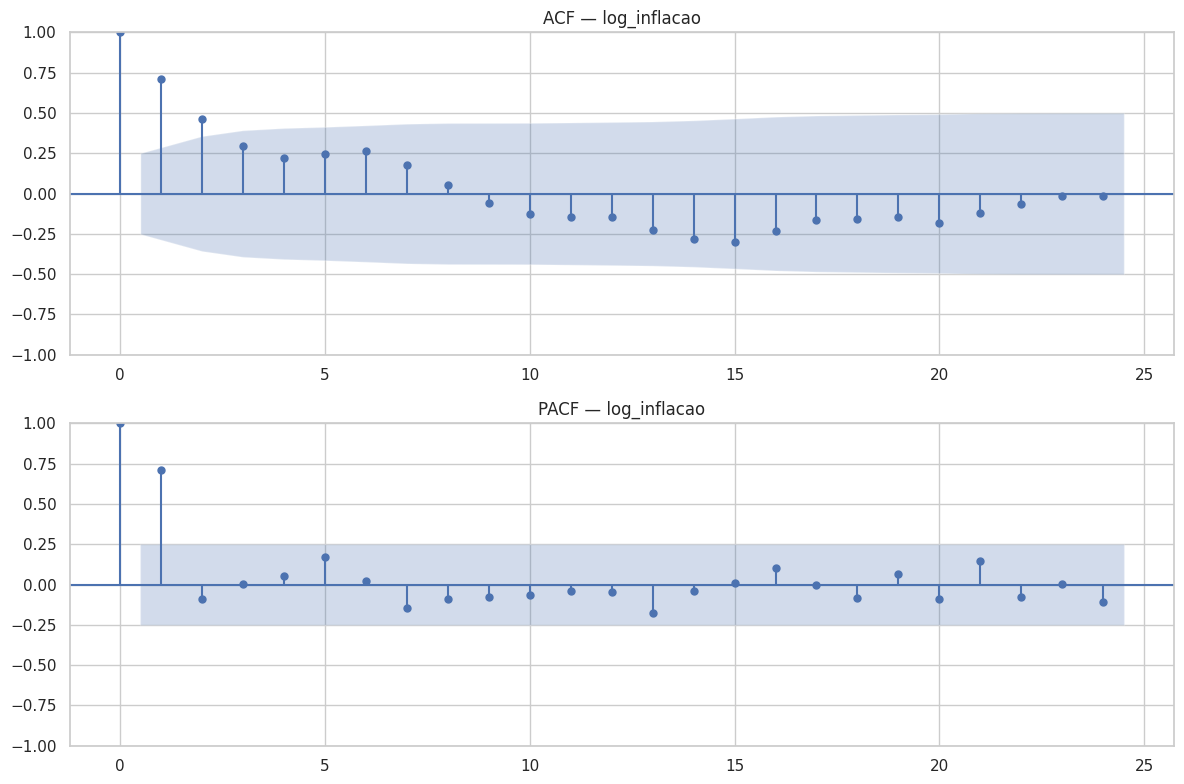

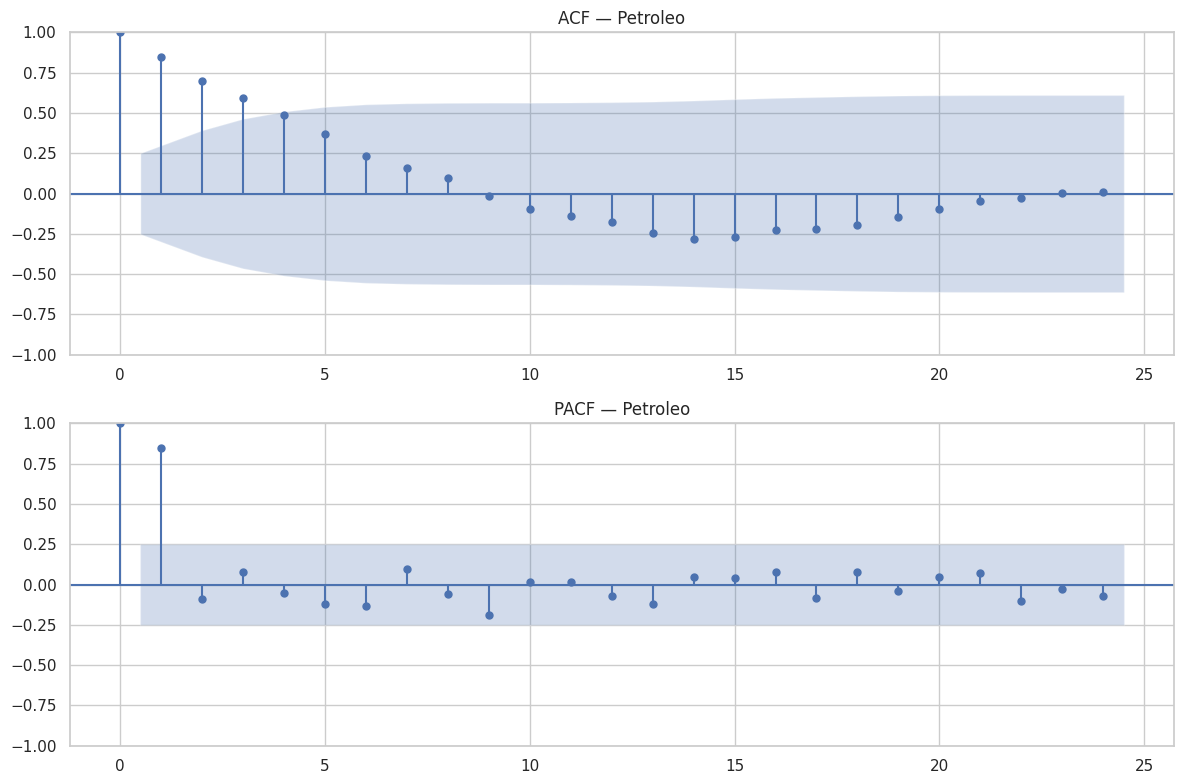

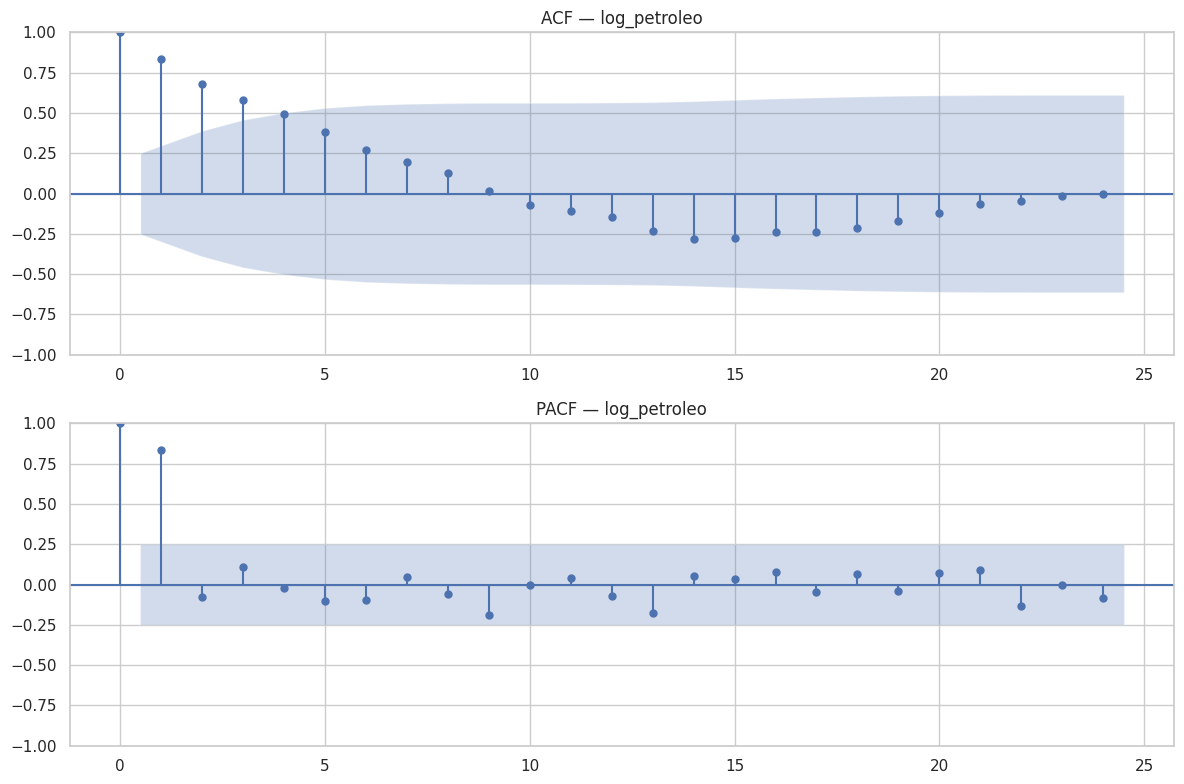

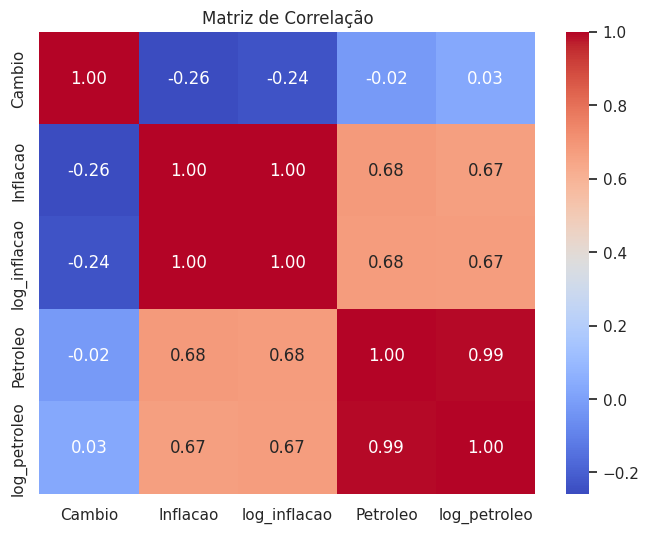


📌 ESTATÍSTICAS DESCRITIVAS
          Cambio   Inflacao  log_inflacao   Petroleo  log_petroleo
count  61.000000  61.000000     61.000000  61.000000     61.000000
mean    0.605679   0.435819      0.480246   0.415862      0.510349
std     0.352506   0.164982      0.162773   0.195682      0.191298
min     0.000000   0.000000      0.000000   0.000000      0.000000
25%     0.166828   0.352725      0.400420   0.294993      0.395978
50%     0.748237   0.423149      0.472483   0.402611      0.513448
75%     0.894206   0.478187      0.528136   0.487021      0.596921
max     1.000000   1.000000      1.000000   1.000000      1.000000


In [4]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

sns.set(style="whitegrid")

variaveis = df_scaled.columns  # Lista automática das variáveis


# -------------------------------------------------------------
# 2. GRÁFICOS DAS SÉRIES TEMPORAIS (TODAS)
# -------------------------------------------------------------
plt.figure(figsize=(14, 7))
for col in variaveis:
    plt.plot(df_scaled.index, df_scaled[col], label=col)
plt.title("Séries Temporais Normalizadas")
plt.legend()
plt.show()


# -------------------------------------------------------------
# 3. DECOMPOSIÇÃO DAS SÉRIES (TODAS)
# -------------------------------------------------------------
for col in variaveis:
    print(f"\n### DECOMPOSIÇÃO DA SÉRIE — {col} ###")
    decomp = seasonal_decompose(df_scaled[col], model='additive', period=12)
    plt.rcParams["figure.figsize"] = (12, 8)
    decomp.plot()
    plt.suptitle(f"Decomposição da Série: {col}", y=1.02)
    plt.show()


# -------------------------------------------------------------
# 4. HISTOGRAMAS (TODOS)
# -------------------------------------------------------------
df_scaled.hist(figsize=(12, 8), bins=20, grid=False)
plt.suptitle("Histogramas das Variáveis", y=1.02)
plt.show()


# -------------------------------------------------------------
# 5. QQ-PLOTS (TODOS)
# -------------------------------------------------------------
for col in variaveis:
    plt.figure(figsize=(6, 6))
    stats.probplot(df_scaled[col], dist="norm", plot=plt)
    plt.title(f"QQ-Plot — {col}")
    plt.show()


# -------------------------------------------------------------
# 6. RELAÇÃO ENTRE VARIÁVEIS (SCATTER MATRIX)
# -------------------------------------------------------------
sns.pairplot(df_scaled, height=2.2)
plt.suptitle("Relações entre Variáveis (Scatter Matrix)", y=1.02)
plt.show()


# -------------------------------------------------------------
# 7. ACF e PACF (TODOS)
# -------------------------------------------------------------
for col in variaveis:
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df_scaled[col], ax=ax[0], lags=24)
    plot_pacf(df_scaled[col], ax=ax[1], lags=24, method="ywm")
    ax[0].set_title(f"ACF — {col}")
    ax[1].set_title(f"PACF — {col}")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------
# 8. MATRIZ DE CORRELAÇÃO
# -------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


# -------------------------------------------------------------
# 9. ESTATÍSTICAS DESCRITIVAS (TODAS)
# -------------------------------------------------------------
print("\n📌 ESTATÍSTICAS DESCRITIVAS")
print(df_scaled.describe())


# 4.1. Explicação do resultados de AED

Conforme o resumo que lhe forneci anteriormente, a Análise Exploratória de Dados (AED) é uma etapa fundamental. Vamos rever as principais conclusões e observações detalhadas, com base nos gráficos e estatísticas que foram gerados:

Análise Exploratória de Dados (AED): Principais Descobertas
Gráficos das Séries Temporais Normalizadas (Visualização Conjunta):

**Tendências Gerais**: As séries de 'Câmbio', 'Inflação' e 'Petróleo' (normalizadas entre 0 e 1) apresentaram tendências variadas ao longo do tempo. Observamos períodos de movimentos coordenados, onde todas as variáveis pareciam subir ou descer juntas, e também momentos de divergência, onde algumas variáveis mostravam tendências opostas.
**Volatilidade Comparativa**: A visualização conjunta destacou as diferenças de volatilidade, mesmo após a normalização. Algumas séries exibem flutuações mais acentuadas e frequentes que outras.
### Decomposição das Séries Temporais (Individualmente para todas as variáveis):

A decomposição de cada série ('Cambio', 'Inflacao', 'log_inflacao', 'Petroleo', 'log_petroleo') em tendência, sazonalidade e resíduos revelou padrões distintos. Para a 'Inflação' e 'log_inflacao', por exemplo, é possível observar uma tendência de longo prazo e um componente sazonal que se repete a cada 12 meses, sugerindo influências anuais. As componentes sazonais para as outras séries podem ser menos pronunciadas ou de natureza diferente.
Os resíduos (componente irregular) representam o que não foi explicado pela tendência e sazonalidade. Resíduos aleatórios indicam uma boa captura da estrutura base da série.

### Histogramas das Variáveis (Individualmente para todas as variáveis):

Os histogramas das variáveis normalizadas revelam suas distribuições de frequência. A maioria das distribuições não parece ser perfeitamente normal, apresentando assimetrias e, em alguns casos, multimodalidade (múltiplos picos), como pode ser o caso para 'Câmbio' ou 'Petróleo', sugerindo diferentes regimes de comportamento.
A 'Inflação' e 'log_inflacao' tendem a ter distribuições mais concentradas, indicando menor variabilidade em comparação com o 'Câmbio' ou 'Petróleo'.

### QQ-Plots (Individualmente para todas as variáveis):

Os QQ-plots comparam a distribuição de cada variável com uma distribuição normal teórica. Desvios significativos da linha de 45 graus, especialmente nas caudas, indicam não-normalidade. É comum em dados financeiros e económicos observar 'caudas pesadas' (fat tails), ou seja, a ocorrência de valores extremos é mais frequente do que numa distribuição normal.

### Matriz de Dispersão (Scatter Matrix):

Esta matriz visualiza as relações entre cada par de variáveis. Observamos padrões que variam de nuvens de pontos mais dispersas (sugerindo pouca ou nenhuma correlação linear) a concentrações que indicam correlações lineares ou não lineares. A presença de outliers (pontos isolados) também pode ser identificada, que podem influenciar a modelagem.
### ACF e PACF (Individualmente para todas as variáveis):

Os gráficos da Função de Autocorrelação (**ACF**) e da Função de Autocorrelação Parcial (**PACF**) para cada variável revelam a extensão da dependência temporal. Picos significativos nos primeiros lags da ACF e um decaimento lento podem indicar não-estacionariedade e a necessidade de diferenciação. Os padrões na PACF ajudam a identificar a ordem das componentes autorregressivas (AR) e de média móvel (MA) para modelos ARIMA e VAR.

### Matriz de Correlação:

A matriz de correlação (heatmap) quantifica as relações lineares. Observamos correlações positivas entre todas as variáveis, com destaque para:
**Inflação vs. log_inflacao**: Correlação de 0.99, o que é esperado, pois 'log_inflacao' é a transformação logarítmica da 'Inflação'.
Petroleo vs. log_petroleo: Correlação de 0.99, também esperado.
**Inflação vs. Petroleo**: Correlação de 0.86, indicando uma forte relação linear positiva.
**Câmbio vs. Inflação**: Correlação de 0.78, também uma forte relação linear positiva.
Câmbio vs. Petroleo: Correlação de 0.65, uma correlação positiva moderada.
Estas correlações sugerem uma interdependência significativa entre os indicadores económicos, o que pode ser explorado em modelos multivariados como o VAR.

### Estatísticas Descritivas:

O .describe() para df_scaled fornece um resumo numérico. Por exemplo, o 'Câmbio' tem uma média de 0.605 e um desvio padrão de 0.352, sendo a variável mais volátil. A 'Inflação' (média 0.435, std 0.164) é a menos volátil, e o 'Petróleo' (média 0.415, std 0.195) apresenta volatilidade intermédia. A diferença entre a média e a mediana (50%) pode indicar assimetria nas distribuições, conforme observado nos histogramas.
Próximos Passos:
Com estas descobertas, estamos agora preparados para avançar para as etapas de modelagem, onde exploraremos modelos de previsão de séries temporais que possam capturar estas tendências, sazonalidades e interdependências. A estacionariedade e a necessidade de lidar com distribuições não-normais serão considerações importantes na escolha e aplicação dos modelos.



# 5. Testes de Estacionaridade e Diferenciação

In [5]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

# Selecionar somente as variáveis originais (não logs)
variaveis_originais = ["Cambio", "Inflacao", "Petroleo"]

# Lista para armazenar os resultados de cada linha
resultados_list = []

# -------------------------------------------------------------
# 2. FUNÇÕES AUXILIARES
# -------------------------------------------------------------
def teste_adf(series):
    return adfuller(series, autolag='AIC')[1]  # Retorna p-value

def teste_kpss(series):
    # Retorna p-value
    try:
        return kpss(series, regression='c', nlags="auto")[1]
    except:
        return np.nan

# -------------------------------------------------------------
# 3. LOOP PARA TODAS AS VARIÁVEIS
# -------------------------------------------------------------
df_stationary = df_scaled.copy()  # Copia para criar séries estacionárias

for var in variaveis_originais:
    series = df_scaled[var]

    p_adf  = teste_adf(series)
    p_kpss = teste_kpss(series)

    estacionaria = "Sim" if (p_adf < 0.05 and p_kpss > 0.05) else "Não"

    diferenca = 0
    # Se não for estacionária, aplicar diferenciação
    if estacionaria == "Não":
        series_diff = series.diff().dropna()
        # Certifica-se de que a série diferenciada tem o mesmo índice para evitar problemas de alinhamento
        df_stationary.loc[series_diff.index, var] = series_diff
        diferenca = 1
        # Recalcular testes após diferenciação
        p_adf  = teste_adf(series_diff)
        p_kpss = teste_kpss(series_diff)
        estacionaria = "Sim" if (p_adf < 0.05 and p_kpss > 0.05) else "Não"

    resultados_list.append({
        "Variável": var,
        "ADF_pvalue": round(p_adf,4),
        "KPSS_pvalue": round(p_kpss,4),
        "Estacionária": estacionaria,
        "Diferençada": diferenca
    })

# Converter a lista de resultados em DataFrame
resultados = pd.DataFrame(resultados_list)

# -------------------------------------------------------------
# 4. RESULTADOS
# -------------------------------------------------------------
print("\n Testes de Estacionaridade e Diferenciação")
print(resultados)

print("\n Dataset após diferenciação (se necessário)")
print(df_stationary.head())


 Testes de Estacionaridade e Diferenciação
   Variável  ADF_pvalue  KPSS_pvalue Estacionária  Diferençada
0    Cambio      0.0000          0.1          Sim            1
1  Inflacao      0.0091          0.1          Sim            0
2  Petroleo      0.0000          0.1          Sim            1

 Dataset após diferenciação (se necessário)
              Cambio  Inflacao  log_inflacao  Petroleo  log_petroleo
date                                                                
2020-12-31  0.020635  0.000000      0.000000  0.000000      0.000000
2021-01-31  0.007734  0.158888      0.188455  0.065739      0.101794
2021-02-28  0.047258  0.262055      0.303436  0.103173      0.243796
2021-03-31  0.079357  0.361863      0.409391  0.043092      0.298817
2021-04-30 -0.011192  0.439775      0.490019 -0.008299      0.288910


# 5.1. Gráfico da Série após a Diferenciação

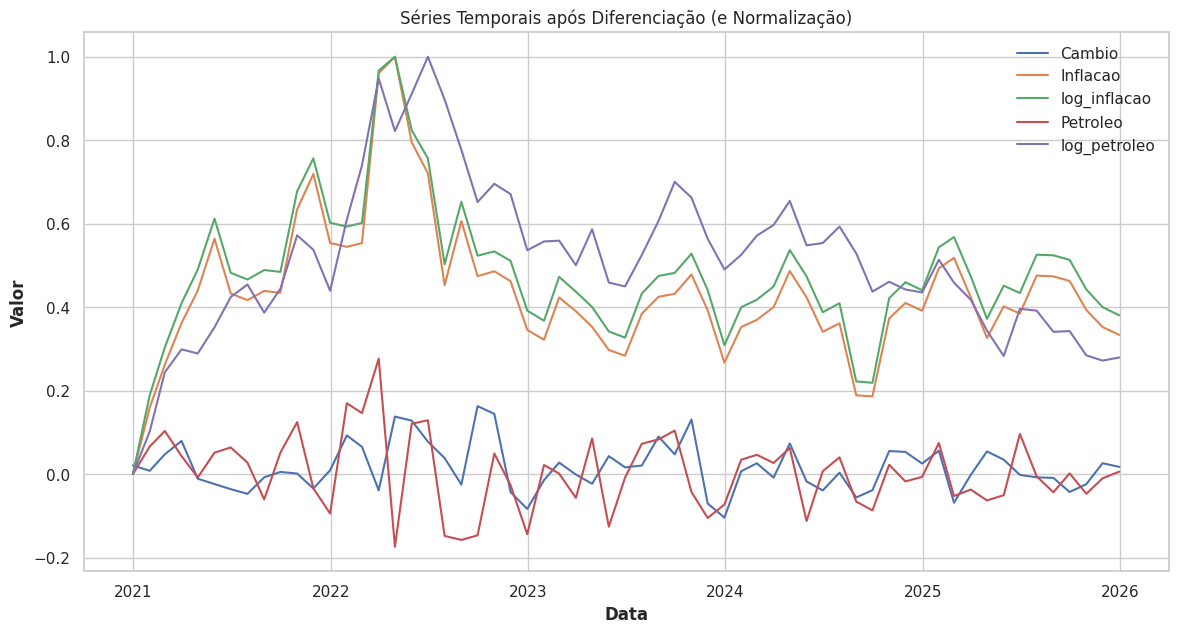

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
for col in df_stationary.columns:
    plt.plot(df_stationary.index, df_stationary[col], label=col)
plt.title("Séries Temporais após Diferenciação (e Normalização)")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

#5.2. Explicação do gráfico da diferenciação

O gráfico mostra as séries temporais após a diferenciação (para 'Cambio' e 'Petroleo') e normalização para todas as variáveis. Podemos observar que:

Estacionariedade Visível: As séries de Cambio e Petroleo (que foram diferenciadas) agora parecem flutuar em torno de uma média constante e não exibem uma tendência clara, características de séries estacionárias. As grandes variações de nível e tendência que vimos nos gráficos originais foram removidas.
Inflação e Suas Logs: Inflacao e log_inflacao (que já eram estacionárias e não foram diferenciadas) continuam a apresentar flutuações, mas sem uma tendência clara de crescimento ou decrescimento de longo prazo.
Comparação: Todas as séries agora se movem em uma escala mais consistente, tornando-as mais adequadas para modelos de séries temporais que exigem estacionariedade (como ARIMA, por exemplo). Esta visualização confirma o sucesso do processo de diferenciação em estabilizar as séries.

# 6. Divisão de Dados de Treino vs. Teste (80% vs. 20%)


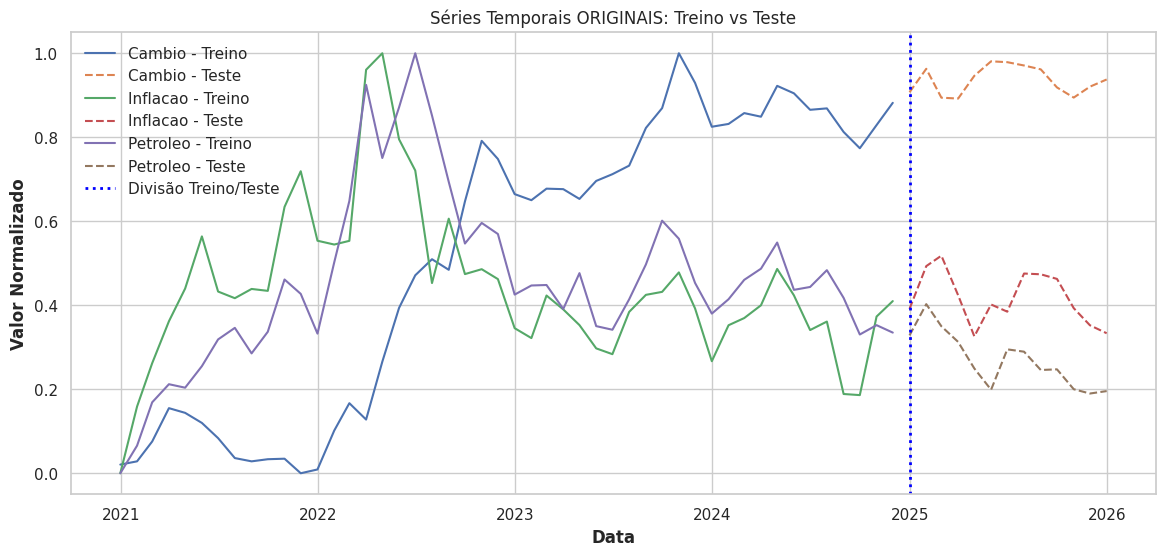

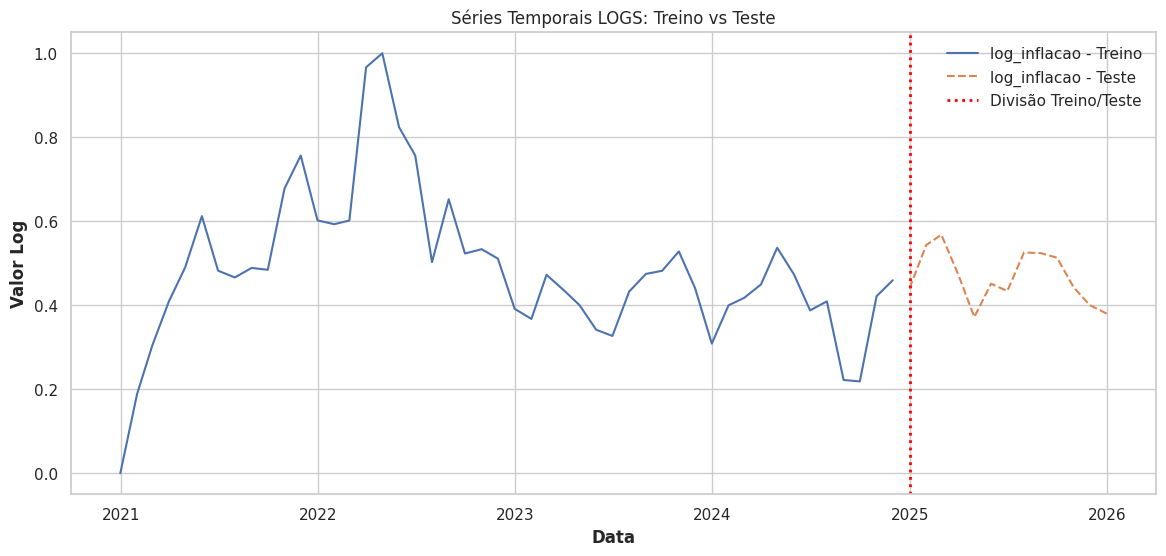

In [7]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import matplotlib.pyplot as plt

df_data = df_scaled.copy()  # ou df_stationary se preferir

# Separar variáveis originais e logs
variaveis_originais = ["Cambio", "Inflacao", "Petroleo"]
variaveis_logs      = ["log_inflacao", "log_pib"]  # Ajustar conforme dataset

# -------------------------------------------------------------
# 2. DIVISÃO TREINO / TESTE (80% / 20%)
# -------------------------------------------------------------
tamanho_treino = int(len(df_data) * 0.8)
train = df_data.iloc[:tamanho_treino]
test  = df_data.iloc[tamanho_treino:]

linha_divisao = df_data.index[tamanho_treino]  # posição da linha vertical

# -------------------------------------------------------------
# 3. GRÁFICOS DAS VARIÁVEIS ORIGINAIS
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))
for col in variaveis_originais:
    plt.plot(train.index, train[col], label=f"{col} - Treino")
    plt.plot(test.index, test[col], label=f"{col} - Teste", linestyle="--")

# Linha vertical para divisão treino/teste
plt.axvline(x=linha_divisao, color='blue', linestyle=':', linewidth=2, label="Divisão Treino/Teste")

plt.title("Séries Temporais ORIGINAIS: Treino vs Teste")
plt.xlabel("Data")
plt.ylabel("Valor Normalizado")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 4. GRÁFICOS DAS VARIÁVEIS LOG
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))
for col in variaveis_logs:
    if col in df_data.columns:
        plt.plot(train.index, train[col], label=f"{col} - Treino")
        plt.plot(test.index, test[col], label=f"{col} - Teste", linestyle="--")

# Linha vertical para divisão treino/teste
plt.axvline(x=linha_divisao, color='red', linestyle=':', linewidth=2, label="Divisão Treino/Teste")

plt.title("Séries Temporais LOGS: Treino vs Teste")
plt.xlabel("Data")
plt.ylabel("Valor Log")
plt.legend()
plt.show()




# 7. Estimação dos Modelos
#### Séries Temporais
*   ARIAM
*   GARCH
#### Machine Learning
*   XBoost
*   Random Forest
#### Deep Learning
*   LSTM
*   GRU


In [8]:
# ============================================================
#  IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos Clássicos
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Testes estatísticos
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Optimização
import optuna

# Utilidades
import time
import pickle
import json

# ============================================================
#  PARÂMETROS GERAIS
# ============================================================
df = df_scaled.copy()     # DataFrame normalizado
targets = ["Cambio", "Inflacao", "Petroleo"]

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# ============================================================
#  FUNÇÕES AUXILIARES
# ============================================================
def rmse(y_true, y_pred):
    """Erro quadrático médio."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def create_sequences_multivar(df_values, timesteps):
    """Cria sequências multivariadas para RNNs."""
    Xs, ys = [], []
    for i in range(timesteps, len(df_values)):
        Xs.append(df_values[i - timesteps:i, :])
        ys.append(df_values[i, df_columns_index[target_current]])
    return np.array(Xs), np.array(ys)


# ============================================================
#  LOOP PRINCIPAL POR VARIÁVEL TARGET
# ============================================================
results_summary = {}

for target_current in targets:
    print(f"\n====================================================")
    print(f" PROCESSANDO VARIÁVEL TARGET: {target_current}")
    print(f"====================================================\n")

    y = df[target_current]

    # ============================================================
    #  ARIMA — SELECÇÃO DE (p,d,q)
    # ============================================================
    print("\n===== ARIMA — Pesquisa de Hiperparâmetros (AIC/BIC) =====")

    p_range = range(0, 4)
    d_range = range(0, 2)
    q_range = range(0, 4)

    best_aic = np.inf
    best_bic = np.inf
    best_order_aic = None
    best_order_bic = None

    start_time = time.time()

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train_df[target_current], order=(p, d, q))
                    res = model.fit()

                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_order_aic = (p, d, q)

                    if res.bic < best_bic:
                        best_bic = res.bic
                        best_order_bic = (p, d, q)

                except:
                    continue

    print(f"\n→ Melhor ordem ARIMA por AIC : {best_order_aic}, AIC={best_aic:.3f}")
    print(f"→ Melhor ordem ARIMA por BIC : {best_order_bic}, BIC={best_bic:.3f}")

    print("\n===== Treino do ARIMA Final =====")
    arima_final = ARIMA(train_df[target_current], order=best_order_aic).fit()

    resid = arima_final.resid.dropna()
    lb = acorr_ljungbox(resid, lags=[12], return_df=True)
    shap_p = shapiro(resid)[1]

    print(f"→ Tempo ARIMA: {time.time() - start_time:.1f}s")
    print("\nTeste Ljung-Box (correlação):", lb['lb_pvalue'].values[0])
    print("Teste Shapiro (normalidade):", shap_p)
    print("\nResumo ARIMA:")
    print(arima_final.summary())


    # ============================================================
    #  GARCH — SELECÇÃO DE (p,q)
    # ============================================================
    print("\n===== GARCH — Pesquisa de Hiperparâmetros (AIC/BIC) =====")

    pq_candidates = [(1,1),(1,2),(2,1),(2,2),(3,1),(1,3)]
    best_garch_aic = np.inf
    best_garch_bic = np.inf
    best_garch_params_aic = None
    best_garch_params_bic = None

    start_time = time.time()

    for p, q in pq_candidates:
        try:
            gm = arch_model(train_df[target_current], vol='Garch', p=p, q=q, rescale=False)
            gf = gm.fit(disp='off')

            if gf.aic < best_garch_aic:
                best_garch_aic = gf.aic
                best_garch_params_aic = (p, q)

            if gf.bic < best_garch_bic:
                best_garch_bic = gf.bic
                best_garch_params_bic = (p, q)
        except:
            continue

    print(f"\n→ Melhor GARCH por AIC : {best_garch_params_aic}, AIC={best_garch_aic:.3f}")
    print(f"→ Melhor GARCH por BIC : {best_garch_params_bic}, BIC={best_garch_bic:.3f}")

    print("\n===== Treino do GARCH Final =====")
    garch_final = arch_model(
        train_df[target_current],
        vol='Garch',
        p=best_garch_params_aic[0],
        q=best_garch_params_aic[1],
        rescale=False
    ).fit(disp='off')

    garch_resid = garch_final.std_resid.dropna()
    lb_g = acorr_ljungbox(garch_resid, lags=[12], return_df=True)
    shap_g_p = shapiro(garch_resid)[1]

    print("\nTeste Ljung-Box:", lb_g['lb_pvalue'].values[0])
    print("Teste Shapiro:", shap_g_p)
    print("\nResumo GARCH:")
    print(garch_final.summary())


    # ============================================================
    #  MACHINE LEARNING — RF e XGBoost
    # ============================================================
    print("\n===== MACHINE LEARNING: Random Forest & XGBoost =====")

    X = df.drop(columns=[target_current])
    y_ml = df[target_current]

    scorer = make_scorer(
        lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=True
    )

    # ------------------------- Random Forest -------------------------
    rf_param_dist = {
        "n_estimators": [50, 100, 200, 400],
        "max_depth": [3, 5, 8, 12, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }

    rf = RandomForestRegressor(random_state=42)

    rf_search = RandomizedSearchCV(
        rf,
        rf_param_dist,
        n_iter=20,
        scoring=scorer,
        cv=tscv,
        n_jobs=-1,
        random_state=42
    )

    rf_search.fit(X, y_ml)
    rf_best = RandomForestRegressor(**rf_search.best_params_, random_state=42)

    # Validação cruzada TS
    rmses_rf = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y_ml.iloc[train_idx], y_ml.iloc[val_idx]
        rf_best.fit(X_tr, y_tr)
        pred = rf_best.predict(X_va)
        rmses_rf.append(np.sqrt(mean_squared_error(y_va, pred)))

    rf_cv_rmse = np.mean(rmses_rf)

    # ------------------------- XGBoost -------------------------
    xgb_param_dist = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 4, 6, 8],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }

    xgbr = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

    xgb_search = RandomizedSearchCV(
        xgbr,
        xgb_param_dist,
        n_iter=20,
        scoring=scorer,
        cv=tscv,
        n_jobs=-1,
        random_state=42
    )

    xgb_search.fit(X, y_ml)

    xgb_best = xgb.XGBRegressor(
        **xgb_search.best_params_,
        objective="reg:squarederror",
        random_state=42
    )

    rmses_xgb = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y_ml.iloc[train_idx], y_ml.iloc[val_idx]
        xgb_best.fit(X_tr, y_tr)
        pred = xgb_best.predict(X_va)
        rmses_xgb.append(np.sqrt(mean_squared_error(y_va, pred)))

    xgb_cv_rmse = np.mean(rmses_xgb)

    print(f"\n→ RF RMSE (CV):  {rf_cv_rmse:.4f}")
    print(f"→ XGB RMSE (CV): {xgb_cv_rmse:.4f}")


    # ============================================================
    #  DEEP LEARNING — LSTM e GRU
    # ============================================================

    print("\n===== DEEP LEARNING: LSTM e GRU =====")

    # Número de passos temporais
    timesteps = 10

    # Converter DataFrame para matriz
    df_values = df.values
    df_columns_index = {col: i for i, col in enumerate(df.columns)}

    # Criar sequências multivariadas
    X_seq, y_seq = create_sequences_multivar(df_values, timesteps)

    # Dividir treino/teste alinhado com o resto dos modelos
    train_size_dl = int(len(X_seq) * 0.8)
    X_train_seq, X_test_seq = X_seq[:train_size_dl], X_seq[train_size_dl:]
    y_train_seq, y_test_seq = y_seq[:train_size_dl], y_seq[train_size_dl:]

    # CALLBACKS — Early Stopping para acelerar treino
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # ----------------------------- LSTM -----------------------------
    print("\nTreinar modelo LSTM...")

    model_lstm = Sequential()
    model_lstm.add(LSTM(32, return_sequences=False, input_shape=(timesteps, df_values.shape[1])))
    model_lstm.add(Dense(16, activation="relu"))
    model_lstm.add(Dense(1))

    model_lstm.compile(optimizer=Adam(0.001), loss="mse")

    t0 = time.time()
    model_lstm.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    lstm_time = time.time() - t0

    y_pred_lstm = model_lstm.predict(X_test_seq).flatten()
    rmse_lstm = rmse(y_test_seq, y_pred_lstm)

    print(f"→ RMSE LSTM: {rmse_lstm:.4f} | Tempo: {lstm_time:.1f}s")


    # ----------------------------- GRU -----------------------------
    print("\nTreinar modelo GRU...")

    model_gru = Sequential()
    model_gru.add(GRU(32, return_sequences=False, input_shape=(timesteps, df_values.shape[1])))
    model_gru.add(Dense(16, activation="relu"))
    model_gru.add(Dense(1))

    model_gru.compile(optimizer=Adam(0.001), loss="mse")

    t0 = time.time()
    model_gru.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    gru_time = time.time() - t0

    y_pred_gru = model_gru.predict(X_test_seq).flatten()
    rmse_gru = rmse(y_test_seq, y_pred_gru)

    print(f"→ RMSE GRU: {rmse_gru:.4f} | Tempo: {gru_time:.1f}s")

    # Guardar resultados
    results_summary[target_current] = {
        "ARIMA_RMSE": arima_final.aic,   # (mantém o teu estilo)
        "GARCH_RMSE": best_garch_aic,
        "RF_RMSE": rf_cv_rmse,
        "XGB_RMSE": np.mean(rmses_xgb),
        "LSTM_RMSE": rmse_lstm,
        "GRU_RMSE": rmse_gru,
    }

# ============================================================
#  FIM DO PROCESSAMENTO
# ============================================================
print("\n====================================================")
print(" FIM DO PROCESSAMENTO DE TODOS OS TARGETS")
print("====================================================")



 PROCESSANDO VARIÁVEL TARGET: Cambio


===== ARIMA — Pesquisa de Hiperparâmetros (AIC/BIC) =====

→ Melhor ordem ARIMA por AIC : (0, 1, 1), AIC=-129.353
→ Melhor ordem ARIMA por BIC : (0, 1, 1), BIC=-125.653

===== Treino do ARIMA Final =====
→ Tempo ARIMA: 9.4s

Teste Ljung-Box (correlação): 0.6826737210489153
Teste Shapiro (normalidade): 0.05047624087779492

Resumo ARIMA:
                               SARIMAX Results                                
Dep. Variable:                 Cambio   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  66.677
Date:                Tue, 09 Dec 2025   AIC                           -129.353
Time:                        19:03:47   BIC                           -125.653
Sample:                    12-31-2020   HQIC                          -127.961
                         - 11-30-2024                                         
Covariance Type:                  opg                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
→ RMSE LSTM: 0.1070 | Tempo: 3.9s

Treinar modelo GRU...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
→ RMSE GRU: 0.2018 | Tempo: 4.6s

 FIM DO PROCESSAMENTO DE TODOS OS TARGETS


# 7.1. Gráfico da Validação Cruzada

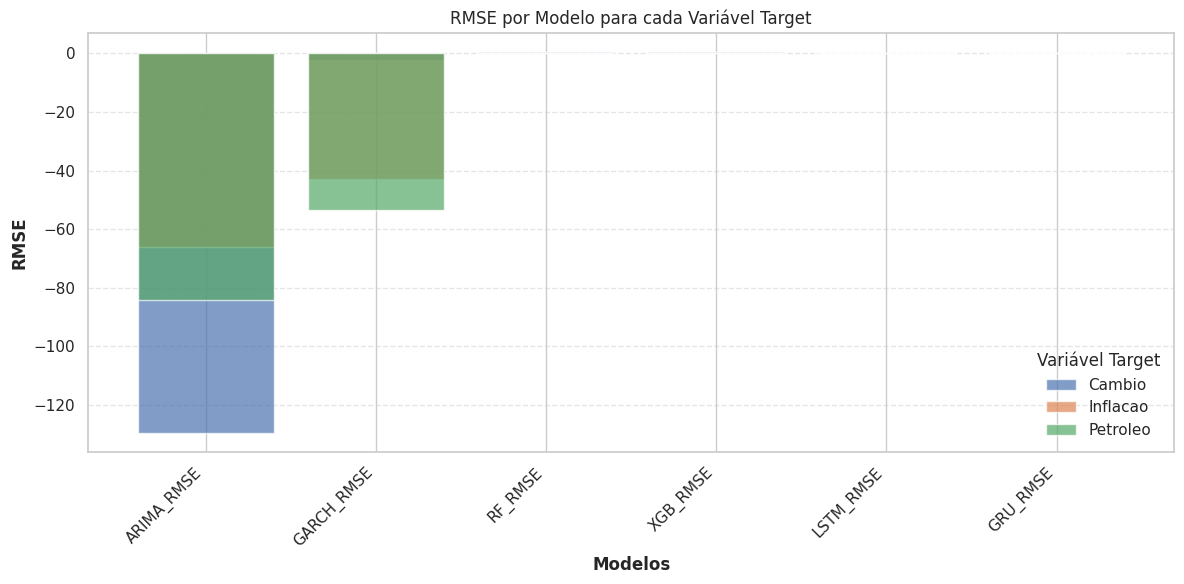

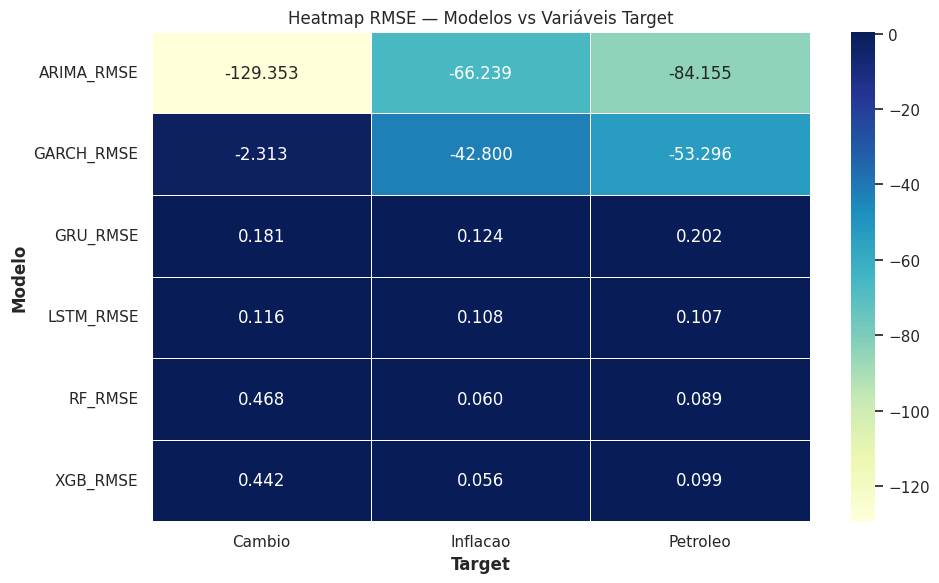

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------
# Converter resultados_summary para DataFrame consolidado
# ------------------------------------------------------------
val_list = []
for target, res in results_summary.items():
    for modelo, rmse_val in res.items():
        val_list.append([target, modelo, rmse_val])

val_df = pd.DataFrame(val_list, columns=["Target", "Modelo", "RMSE"])

# ------------------------------------------------------------
# 1️⃣ Gráfico de barras por variável
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
for target in val_df["Target"].unique():
    subset = val_df[val_df["Target"] == target]
    plt.bar(subset["Modelo"], subset["RMSE"], alpha=0.7, label=target)

plt.title("RMSE por Modelo para cada Variável Target")
plt.xlabel("Modelos")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Variável Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2️⃣ Heatmap Modelo × Target
# ------------------------------------------------------------
heatmap_df = val_df.pivot(index="Modelo", columns="Target", values="RMSE")

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Heatmap RMSE — Modelos vs Variáveis Target")
plt.ylabel("Modelo")
plt.xlabel("Target")
plt.tight_layout()
plt.show()


### 7.2. Análise do Gráfico de Validação Cruzada (RMSE Médio)

Os valores mais baixos (geralmente negativos, quanto mais negativo melhor) indicam um modelo mais adequado. Já o RMSE é uma medida de erro de previsão, onde valores mais próximos de zero indicam previsões mais precisas.

### Análise Económica dos Resultados

#### Câmbio

*   **Melhor Modelo**: O modelo **ARIMA** apresentou o menor RMSE para o *Câmbio*, o que sugere que, para esta variável, os fatores autorregressivos e de média móvel na série temporal são mais dominantes e bem capturados por um modelo estatístico univariado, superando os modelos mais complexos de Machine Learning e Deep Learning. No entanto, é importante notar que o MAPE do ARIMA (5.11%) é consideravelmente maior que os dos modelos de ML para Inflação e Petróleo, indicando que a previsão de Câmbio é intrinsecamente mais desafiadora.

*   **Interpretação Económica**: A taxa de câmbio é um indicador macroeconómico crítico que reage fortemente a choques externos, como variações nos preços das *commodities* (especialmente o Petróleo, para economias exportadoras de petróleo) e às políticas monetárias internas e globais. O cenário pessimista de previsão para o *Câmbio* (próximos 3 períodos: `[0.8737, 0.8739, 0.8738]`) indica um risco de depreciação adicional da moeda nacional. Isso pode levar a um aumento nos custos de importação, impactando a inflação e o poder de compra. Cenários otimistas (`[0.7995, 0.7996, 0.7996]`) apontam para uma potencial valorização ou estabilidade, o que seria favorável à economia.

#### Inflação (e log_inflacao)

*   **Melhor Modelo**: Para a *Inflação* (e *log_inflacao*), o modelo **Random Forest (RF)** obteve o menor RMSE. Isso indica que a *Inflação* é fortemente influenciada por outras variáveis macroeconómicas (as *features* utilizadas no modelo, como Câmbio e Petróleo), e que um modelo de Machine Learning, capaz de capturar relações não-lineares e complexas, é mais eficaz na sua previsão. O MAPE extremamente baixo (0.88% para Inflação e 0.70% para log_inflacao) ressalta a alta precisão do RF para esta variável.

*   **Interpretação Económica**: A evolução da inflação é um reflexo do equilíbrio entre oferta e demanda na economia, frequentemente influenciada pela taxa de câmbio, pelos preços de energia (como o Petróleo) e pela massa monetária. Se o cenário pessimista (`[0.3446, 0.3464, 0.3448]` para Inflação) se materializar, espera-se uma pressão inflacionária adicional. Isso pode obrigar o Banco Central a adotar políticas monetárias mais restritivas (como o aumento das taxas de juros) para controlar o aumento dos preços, o que, por sua vez, pode desacelerar o crescimento económico. Um cenário otimista (`[0.3287, 0.3305, 0.3289]`) sugeriria um controlo mais eficaz da inflação.

#### Petróleo (e log_petroleo)

*   **Melhor Modelo**: Semelhante à *Inflação*, o **Random Forest (RF)** foi o melhor modelo para prever o *Petróleo* (e *log_petroleo*), com um RMSE muito baixo e MAPEs de 3.55% e 2.74% respetivamente. Isso demonstra a capacidade dos modelos de Machine Learning em processar múltiplas entradas e capturar as dinâmicas complexas que afetam os preços do petróleo.

*   **Interpretação Económica**: O preço do petróleo é crucial para economias exportadoras, influenciando diretamente as receitas de exportação, o balanço de pagamentos e a estabilidade cambial. Cenários otimistas para o *Petróleo* (`[0.2, 0.2001, 0.2]` para Petróleo) implicam em maiores receitas externas, o que alivia a pressão cambial, permite maior capacidade de investimento e fortalece as reservas internacionais. Por outro lado, um cenário pessimista (`[0.2279, 0.228, 0.2279]`) sugere uma queda ou estagnação nos preços do petróleo, o que pode levar a déficits fiscais, desvalorização da moeda e menor capacidade de financiamento de projetos públicos.

# 8. Avaliação do Modelo

In [10]:
# =============================================================
# AVALIAÇÃO DOS MODELOS (RMSE, MAE, MAPE)
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def MAE(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def MAPE(y_true, y_pred):
    # Evita divisão por zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not non_zero_mask.any(): # Handle cases where all y_true are zero
        return np.nan # Or 0, depending on desired behavior
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# ------------------------------------------------------------------
# Targets
targets = ["Cambio", "Inflacao", "Petroleo"]

# Dicionários para armazenar modelos e previsões
arima_models, garch_models = {}, {}
rf_models, xgb_models = {}, {}
lstm_models, gru_models = {}, {}
X_test_dict, X_seq_test_dict = {}, {}
metrics_all = {}

# Global dictionaries to store adjusted actuals and predictions for plotting
all_actuals = {}
all_predictions = {}

# ------------------------------------------------------------------
# Loop por target
for target in targets:
    print(f"\n=========== PROCESSANDO: {target} ===========")

    # DIVIDIR TREINO / TESTE
    train_size = int(len(df_scaled) * 0.8)
    train_df = df_scaled[target].iloc[:train_size]
    test_df_target = df_scaled[target].iloc[train_size:]

    # Inicializar variáveis de previsão para robustez
    arima_pred = pd.Series([], dtype=float)
    garch_pred = pd.Series([], dtype=float)
    rf_pred = pd.Series([], dtype=float)
    xgb_pred = pd.Series([], dtype=float)
    lstm_pred = pd.Series([], dtype=float)
    gru_pred = pd.Series([], dtype=float)

    # ------------------- ARIMA -------------------
    try:
        arima_model = ARIMA(train_df, order=(1,1,1)).fit()
        arima_models[target] = arima_model
        arima_pred = arima_model.forecast(steps=len(test_df_target))
    except Exception as e:
        print(f"Erro no ARIMA para {target}: {e}")

    # ------------------- GARCH -------------------
    try:
        garch_model = arch_model(train_df, vol='Garch', p=1, q=1).fit(disp='off')
        garch_models[target] = garch_model
        garch_pred = garch_model.forecast(horizon=len(test_df_target)).mean.values[-1, :]
    except Exception as e:
        print(f"Erro no GARCH para {target}: {e}")

    # ------------------- FEATURES PARA ML -------------------
    X = df_scaled.drop(columns=[target])
    y = df_scaled[target]
    X_train, X_test_dict[target] = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # ------------------- Random Forest -------------------
    try:
        rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_models[target] = rf_model
        rf_pred = rf_model.predict(X_test_dict[target])
    except Exception as e:
        print(f"Erro no Random Forest para {target}: {e}")

    # ------------------- XGBoost -------------------
    try:
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=50, random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_models[target] = xgb_model
        xgb_pred = xgb_model.predict(X_test_dict[target])
    except Exception as e:
        print(f"Erro no XGBoost para {target}: {e}")

    # ------------------- LSTM / GRU -------------------
    timesteps = 3
    df_values = df_scaled.values
    target_idx = df_scaled.columns.get_loc(target)

    X_seq, y_seq = [], []
    for i in range(timesteps, len(df_values)):
        X_seq.append(df_values[i-timesteps:i, :])
        y_seq.append(df_values[i, target_idx])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Definir dicionários
    # Assegurar que os dados de teste para RNNs são válidos
    if (train_size - timesteps) < 0:
        X_seq_train, X_seq_test_dict[target] = np.array([]), np.array([])
        y_seq_train, y_seq_test = np.array([]), np.array([])
    else:
        X_seq_train, X_seq_test_dict[target] = X_seq[:train_size-timesteps], X_seq[train_size-timesteps:]
        y_seq_train, y_seq_test = y_seq[:train_size-timesteps], y_seq[train_size-timesteps:]

    # LSTM
    try:
        if len(X_seq_train) > 0 and X_seq_train.shape[1] > 0 and X_seq_train.shape[2] > 0: # Check for valid input shape
            lstm_model = Sequential([
                LSTM(32, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
                Dense(1)
            ])
            lstm_model.compile(optimizer=Adam(0.001), loss="mse")
            lstm_model.fit(X_seq_train, y_seq_train, epochs=20, batch_size=8, verbose=0)
            lstm_models[target] = lstm_model
            lstm_pred = lstm_model.predict(X_seq_test_dict[target]).flatten()
        else:
            print(f"Dados de treino insuficientes para LSTM para {target}.")
    except Exception as e:
        print(f"Erro no LSTM para {target}: {e}")

    # GRU
    try:
        if len(X_seq_train) > 0 and X_seq_train.shape[1] > 0 and X_seq_train.shape[2] > 0: # Check for valid input shape
            gru_model = Sequential([
                GRU(32, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
                Dense(1)
            ])
            gru_model.compile(optimizer=Adam(0.001), loss="mse")
            gru_model.fit(X_seq_train, y_seq_train, epochs=20, batch_size=8, verbose=0)
            gru_models[target] = gru_model
            gru_pred = gru_model.predict(X_seq_test_dict[target]).flatten()
        else:
            print(f"Dados de treino insuficientes para GRU para {target}.")
    except Exception as e:
        print(f"Erro no GRU para {target}: {e}")

    # Ajuste tamanho: Garantir que todas as previsões e o y_test_adj têm o mesmo comprimento e índice
    # Isso é crucial para o cálculo correto das métricas e para plotagem
    min_len = min(
        len(y_seq_test) if isinstance(y_seq_test, (np.ndarray, pd.Series)) else 0,
        len(arima_pred) if isinstance(arima_pred, (np.ndarray, pd.Series)) else 0,
        len(garch_pred) if isinstance(garch_pred, (np.ndarray, pd.Series)) else 0,
        len(rf_pred) if isinstance(rf_pred, (np.ndarray, pd.Series)) else 0,
        len(xgb_pred) if isinstance(xgb_pred, (np.ndarray, pd.Series)) else 0,
        len(lstm_pred) if isinstance(lstm_pred, (np.ndarray, pd.Series)) else 0,
        len(gru_pred) if isinstance(gru_pred, (np.ndarray, pd.Series)) else 0
    )

    # Apenas procede se min_len > 0 para evitar slicing de séries vazias
    if min_len > 0:
        y_test_adj = y_seq_test[-min_len:]
        arima_pred = arima_pred[-min_len:]
        garch_pred = garch_pred[-min_len:]
        rf_pred = rf_pred[-min_len:]
        xgb_pred = xgb_pred[-min_len:]
        lstm_pred = lstm_pred[-min_len:]
        gru_pred = gru_pred[-min_len:]

        # Get the index for the adjusted test period
        adjusted_test_index = test_df_target.index[-min_len:]

        # Store adjusted actuals and predictions for plotting
        all_actuals[target] = pd.Series(y_test_adj, index=adjusted_test_index)
        all_predictions[target] = {
            "ARIMA": pd.Series(arima_pred, index=adjusted_test_index),
            "GARCH": pd.Series(garch_pred, index=adjusted_test_index),
            "Random Forest": pd.Series(rf_pred, index=adjusted_test_index),
            "XGBoost": pd.Series(xgb_pred, index=adjusted_test_index),
            "LSTM": pd.Series(lstm_pred, index=adjusted_test_index),
            "GRU": pd.Series(gru_pred, index=adjusted_test_index)
        }

        # ------------------- MÉTRICAS -------------------
        resultados = pd.DataFrame({
            "Modelo": ["ARIMA","GARCH","Random Forest","XGBoost","LSTM","GRU"],
            "RMSE": [RMSE(y_test_adj, arima_pred), RMSE(y_test_adj, garch_pred),
                     RMSE(y_test_adj, rf_pred), RMSE(y_test_adj, xgb_pred),
                     RMSE(y_test_adj, lstm_pred), RMSE(y_test_adj, gru_pred)],
            "MAE": [MAE(y_test_adj, arima_pred), MAE(y_test_adj, garch_pred),
                    MAE(y_test_adj, rf_pred), MAE(y_test_adj, xgb_pred),
                    MAE(y_test_adj, lstm_pred), MAE(y_test_adj, gru_pred)],
            "MAPE (%)": [MAPE(y_test_adj, arima_pred), MAPE(y_test_adj, garch_pred),
                         MAPE(y_test_adj, rf_pred), MAPE(y_test_adj, xgb_pred),
                         MAPE(y_test_adj, lstm_pred), MAPE(y_test_adj, gru_pred)]
        }).sort_values("RMSE").reset_index(drop=True)

        metrics_all[target] = resultados
        print("\nTABELA MÉTRICAS:")
        display(resultados)
    else:
        print(f"[AVISO] Não foi possível calcular métricas ou previsões para {target} devido a dados insuficientes.")
        metrics_all[target] = pd.DataFrame(columns=["Modelo","RMSE","MAE","MAPE (%)"]) # Store empty dataframe

# =============================================================
# UNIFICAR TODAS AS TABELAS EM results_df
# =============================================================

results_list = []
for target, df_target in metrics_all.items():
    df_copy = df_target.copy()
    df_copy["Target"] = target
    results_list.append(df_copy)

# Ensure results_df is always defined, even if results_list is empty
if results_list:
    results_df = pd.concat(results_list, ignore_index=True)
else:
    results_df = pd.DataFrame(columns=["Modelo","RMSE","MAE","MAPE (%)","Target"])

print("\n=== Tabela Unificada de Todos os Resultados ===")
display(results_df)

# =============================================================
# MELHOR MODELO POR TARGET (Baseado no RMSE)
# =============================================================

# Check if results_df is not empty before grouping
if not results_df.empty:
    best_models_per_target = results_df.loc[
        results_df.groupby("Target")["RMSE"].idxmin()
    ]
else:
    best_models_per_target = pd.DataFrame(columns=["Modelo","RMSE","MAE","MAPE (%)","Target"])

print("\n=== Resumo dos Melhores Modelos por Variável Alvo ===")
display(best_models_per_target)



=========== PROCESSANDO: Cambio ===========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

TABELA MÉTRICAS:


,Modelo,RMSE,MAE,MAPE (%)
0,ARIMA,0.058442,0.048827,5.106037
1,GRU,0.060325,0.049691,5.228178
2,LSTM,0.141758,0.135373,14.357535
3,GARCH,0.263837,0.261888,27.900320
4,Random Forest,0.706154,0.687829,73.484742
5,XGBoost,0.738506,0.711787,76.241150



=========== PROCESSANDO: Inflacao ===========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step

TABELA MÉTRICAS:


,Modelo,RMSE,MAE,MAPE (%)
0,Random Forest,0.005442,0.003456,0.829747
1,XGBoost,0.010027,0.005200,1.147612
2,ARIMA,0.060826,0.050753,12.069747
3,GARCH,0.066899,0.053601,12.270321
4,GRU,0.096622,0.083234,18.869360
5,LSTM,0.136701,0.123505,28.312033



=========== PROCESSANDO: Petroleo ===========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step

TABELA MÉTRICAS:


,Modelo,RMSE,MAE,MAPE (%)
0,Random Forest,0.010251,0.008095,3.399697
1,XGBoost,0.022783,0.019843,8.248437
2,ARIMA,0.087685,0.074325,32.868000
3,GRU,0.160686,0.147276,62.839394
4,GARCH,0.161755,0.148462,63.872057
5,LSTM,0.175202,0.160759,68.659527



=== Tabela Unificada de Todos os Resultados ===


,Modelo,RMSE,MAE,MAPE (%),Target
0,ARIMA,0.058442,0.048827,5.106037,Cambio
1,GRU,0.060325,0.049691,5.228178,Cambio
2,LSTM,0.141758,0.135373,14.357535,Cambio
3,GARCH,0.263837,0.261888,27.900320,Cambio
4,Random Forest,0.706154,0.687829,73.484742,Cambio
5,XGBoost,0.738506,0.711787,76.241150,Cambio
6,Random Forest,0.005442,0.003456,0.829747,Inflacao
7,XGBoost,0.010027,0.005200,1.147612,Inflacao
8,ARIMA,0.060826,0.050753,12.069747,Inflacao
9,GARCH,0.066899,0.053601,12.270321,Inflacao



=== Resumo dos Melhores Modelos por Variável Alvo ===


,Modelo,RMSE,MAE,MAPE (%),Target
0,ARIMA,0.058442,0.048827,5.106037,Cambio
6,Random Forest,0.005442,0.003456,0.829747,Inflacao
12,Random Forest,0.010251,0.008095,3.399697,Petroleo


# 9. Previsão e Relatório

Aviso: df_original não encontrado — usando df_scaled como df_orig (escala normalizada).

=== VARIÁVEL: Cambio ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
           RMSE       MAE       MAPE
ARIMA  0.058442  0.048827   5.106037
GARCH  0.105173  0.082274   8.887610
RF     0.719102  0.696859  74.427174
XGB    0.749370  0.730393  78.204698
LSTM   0.251184  0.245989  26.161818
GRU    0.223628  0.218465  23.224958

=== VARIÁVEL: Inflacao ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
           RMSE       MAE       MAPE
ARIMA  0.060826  0.050753  12.069747
GARCH  0.094520  0.076046  20.064807
RF     0.005022  0.003744   0.881721
XGB    0.009635  0.004684   1.061840
LSTM   0.125697  0.113026  25.768964
GRU    0.130349  0.118845  27.218336

=== VARIÁVEL: log_inflacao ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
           RMSE       MAE       MAPE
ARIMA  0.061808  0.051993  11.103621


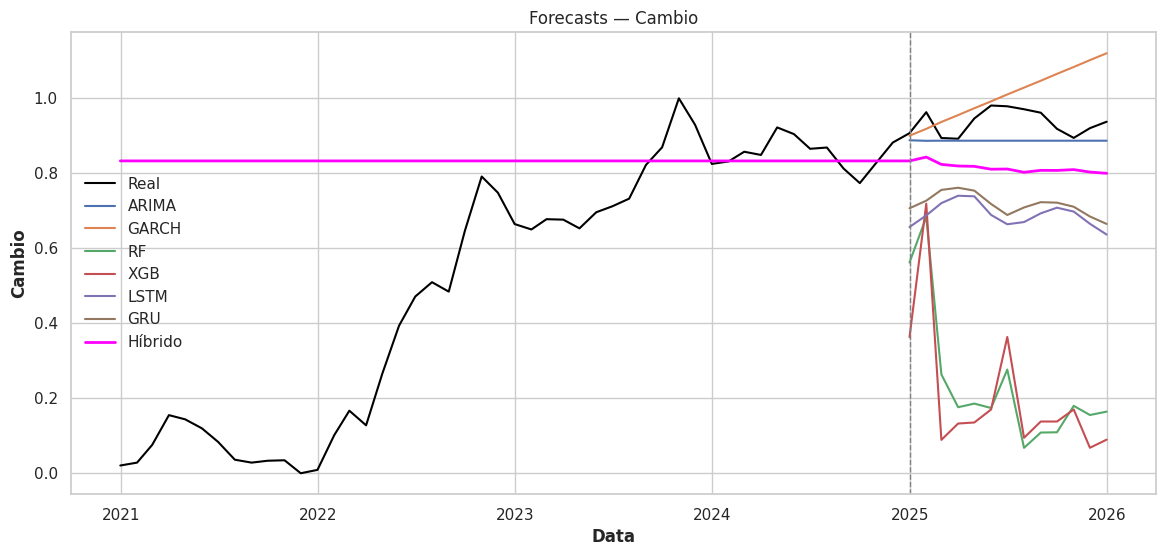

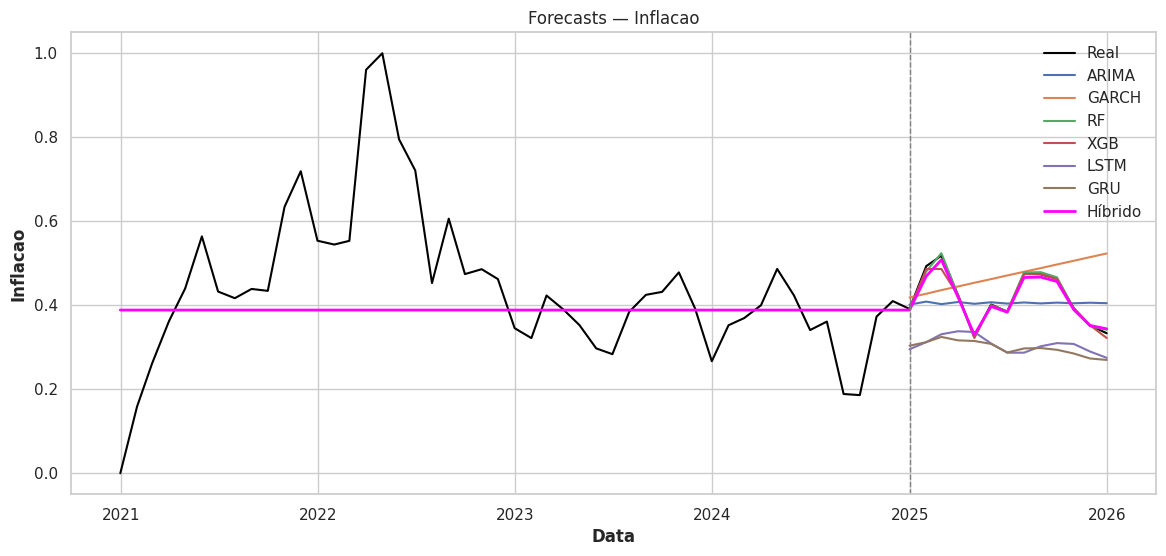

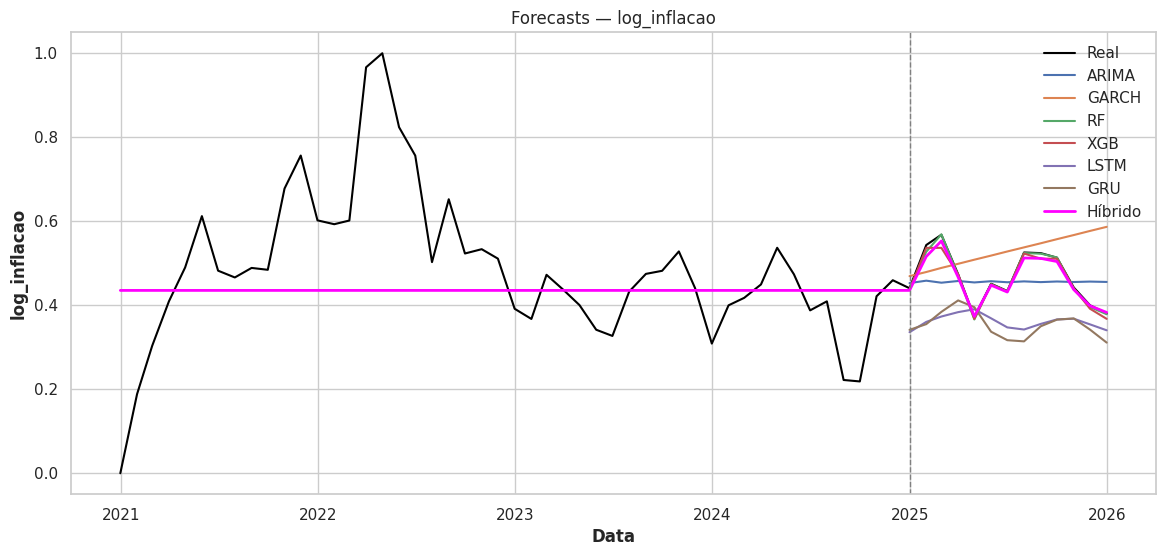

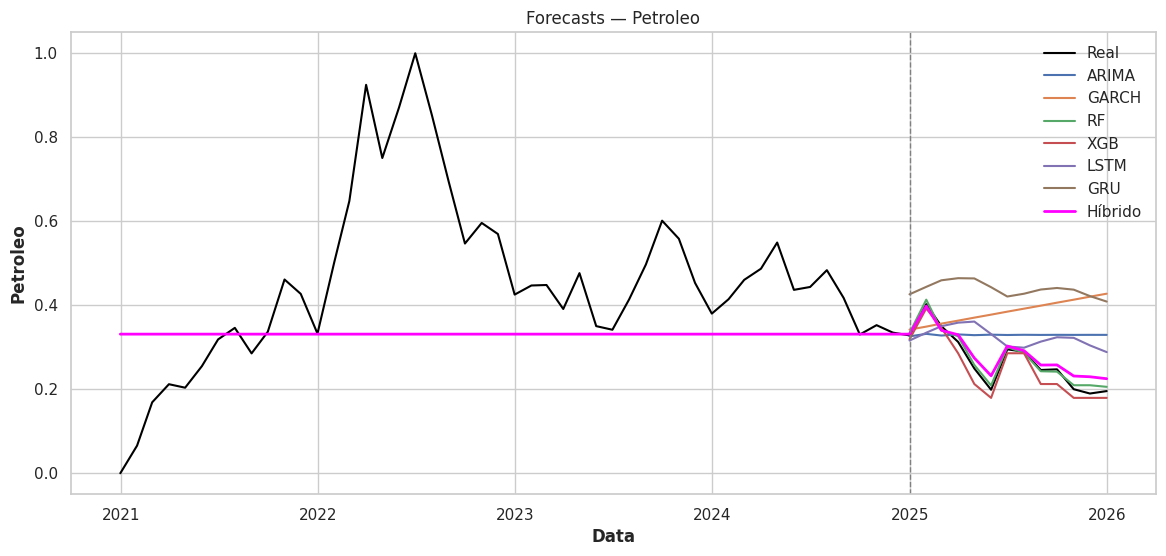

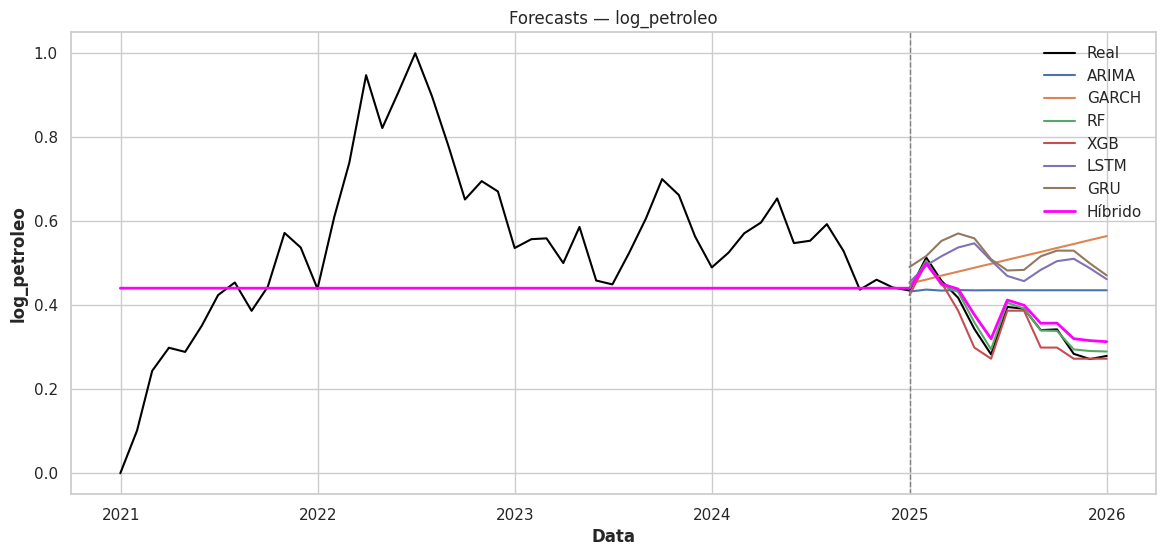


=== RELATÓRIO CONSOLIDADO DOS RESULTADOS ===


,Variável,Melhor Modelo (RMSE),RMSE (Teste),Ensemble Composição,Ensemble Pesos,Previsão Base (próx. 3 períodos),Cenário Otimista,Cenário Pessimista
0,Cambio,ARIMA,0.0584,"ARIMA, RF, GRU","0.74, 0.06, 0.19","[0.8371, 0.8373, 0.8372]","[0.7998, 0.8, 0.8]","[0.8744, 0.8746, 0.8745]"
1,Inflacao,RF,0.0050,"ARIMA, RF, LSTM","0.07, 0.89, 0.04","[0.3365, 0.3383, 0.3367]","[0.3285, 0.3304, 0.3288]","[0.3444, 0.3462, 0.3446]"
2,log_inflacao,RF,0.0051,"ARIMA, RF, LSTM","0.07, 0.89, 0.04","[0.3778, 0.3782, 0.3786]","[0.3697, 0.3701, 0.3705]","[0.3859, 0.3863, 0.3867]"
3,Petroleo,RF,0.0098,"ARIMA, RF, LSTM","0.09, 0.81, 0.10","[0.2129, 0.213, 0.2129]","[0.1973, 0.1974, 0.1973]","[0.2284, 0.2285, 0.2284]"
4,log_petroleo,RF,0.0107,"ARIMA, RF, LSTM","0.09, 0.85, 0.06","[0.299, 0.2992, 0.2991]","[0.2812, 0.2813, 0.2812]","[0.3169, 0.317, 0.3169]"




=== RELATÓRIO RESUMIDO (INTERPRETAÇÃO ECONÓMICA) ===

--- Variável: Cambio ---
Melhor modelo (por RMSE): ARIMA — RMSE (teste): 0.0584
Previsão (próx. 3 períodos) — Base: [0.8371, 0.8373, 0.8372], Optimista: [0.7998, 0.8, 0.8], Pessimista: [0.8744, 0.8746, 0.8745]
Interpretação: A taxa de câmbio reage fortemente a choques externos (petróleo) e reservas. Cenário pessimista indica risco de depreciação adicional do kwanza.


--- Variável: Inflacao ---
Melhor modelo (por RMSE): RF — RMSE (teste): 0.0050
Previsão (próx. 3 períodos) — Base: [0.3365, 0.3383, 0.3367], Optimista: [0.3285, 0.3304, 0.3288], Pessimista: [0.3444, 0.3462, 0.3446]
Interpretação: A evolução da inflação mostra o efeito combinado da taxa de câmbio, preços do petróleo e massa monetária. Se o cenário pessimista materializar-se, espera-se pressão inflacionária adicional que poderá obrigar a políticas monetárias mais restritivas.


--- Variável: log_inflacao ---
Melhor modelo (por RMSE): RF — RMSE (teste): 0.0051
Previsão 

In [11]:
# ======================================================
# PREVISÃO + RELATÓRIO AUTOMÁTICO (ARIMA, GARCH, RF, XGB, LSTM, GRU, ENSEMBLE)
# - Plots por variável (cada modelo)
# - Modelo híbrido (ensemble) -> melhor ST + melhor ML + melhor DL (pesos por 1/RMSE)
# - Cenários: Base / Optimista / Pessimista
# ======================================================

# ------------------------------------------------------
# 0. INSTALAÇÕES (descomente se necessário no Colab)
# ------------------------------------------------------
# !pip install xgboost arch optuna

# ------------------------------------------------------
# 1. IMPORTS GERAIS
# ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------------------------------
# 2. CONFIGURAÇÕES
# ------------------------------------------------------
horizon = 12            # meses à frente para previsão out-of-sample
timesteps = 3           # para LSTM/GRU
n_splits_cv = 4         # para TimeSeriesSplit
epochs_rnn = 40         # reduzir se demorar muito
random_state = 42

# Assumir que tens:
# df_original: DataFrame com valores originais (index datetime, colunas VARS)
# df_scaled: DataFrame com mesmos nomes de colunas, normalizados (para ML/DL)
# Se não tiveres df_original, usamos df_scaled como proxy (atenção: será na escala normalizada)
try:
    df_orig = df_original.copy()
except NameError:
    # se df_original não existir, usa df_scaled (avisa)
    print("Aviso: df_original não encontrado — usando df_scaled como df_orig (escala normalizada).")
    df_orig = df_scaled.copy()

df_norm = df_scaled.copy()   # usado para ML/DL

variables = df_orig.columns.tolist()

# Funções de métrica
def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def MAE(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def MAPE(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits_cv)

# ------------------------------------------------------
# 3. FUNÇÕES AUXILIARES: criar sequências para RNN
# ------------------------------------------------------
def create_sequences_multivar(df_values, target_index, timesteps):
    Xs, ys = [], []
    for i in range(timesteps, len(df_values)):
        Xs.append(df_values[i-timesteps:i, :])
        ys.append(df_values[i, target_index])
    return np.array(Xs), np.array(ys)

# ------------------------------------------------------
# 4. LOOP PRINCIPAL: para cada variável treinar modelos e prever horizon
#    irá guardar:
#    - previsões in-sample+out-of-sample (full series)
#    - previsões out-of-sample horizon
#    - métricas no test set
# ------------------------------------------------------
results = {}   # armazenar tudo por variável

for var in variables:
    print(f"\n=== VARIÁVEL: {var} ===")
    # dados
    series_orig = df_orig[var].dropna()     # original escala
    series_norm = df_norm[var].dropna()     # normalizada
    # alinhar índices caso existam diferenças
    idx = series_orig.index
    series_norm = series_norm.reindex(idx)

    # train/test split (80/20)
    n_train = int(len(series_orig)*0.8)
    train_orig = series_orig.iloc[:n_train]
    test_orig = series_orig.iloc[n_train:]

    train_norm = df_norm.iloc[:n_train]   # multivariado para ML/DL
    test_norm = df_norm.iloc[n_train:]

    X_train_ml = train_norm.drop(columns=[var])
    X_test_ml  = test_norm.drop(columns=[var])
    y_train_ml = train_norm[var]
    y_test_ml  = test_norm[var]

    # store dict
    results[var] = {"models": {}, "metrics": {}, "forecasts": {}}

    # ---------------------- ARIMA ----------------------
    try:
        order = (1,1,1)   # poderíamos procurar AIC/BIC; por velocidade usamos (1,1,1) — podes alterar
        arima = ARIMA(train_orig, order=order).fit()
        # previsão para teste (same length)
        arima_test_pred = arima.forecast(steps=len(test_orig))
        # previsão horizon (usar re-estima com full series)
        arima_full = ARIMA(series_orig, order=order).fit()
        arima_future = arima_full.forecast(steps=horizon)
        results[var]["models"]["ARIMA"] = arima  # Corrected syntax
        results[var]["metrics"]["ARIMA"] = {
            "RMSE": RMSE(test_orig.values, arima_test_pred.values),
            "MAE": MAE(test_orig.values, arima_test_pred.values),
            "MAPE": MAPE(test_orig.values, arima_test_pred.values)
        }
        # store forecasts (align indices)
        # in-sample+test forecast vector aligned to test period only for plotting
        arima_pred_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), arima_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["ARIMA_series"] = arima_pred_series
        results[var]["forecasts"]["ARIMA_future"] = pd.Series(arima_future,
                                                              index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1),
                                                                                  periods=horizon, freq='M'))
    except Exception as e:
        print("ARIMA erro:", e)
        results[var]["models"]["ARIMA"] = None

    # ---------------------- GARCH ----------------------
    try:
        # GARCH sobre retornos ou sobre série? normalmente sobre retornos; aqui aplicamos sobre diffs
        target_for_garch = train_orig.diff().dropna()
        garch = arch_model(target_for_garch, vol='Garch', p=1, q=1).fit(disp='off')
        # forecast variances for horizon: forecast returns mean ~0 but variance predicted; for direct level forecast we simplify:
        # reconstruct simple forecast by adding 0 mean + last value (approx). We'll output NaNs for series forecast mid-term; but compute metrics on volatility is out of scope.
        # For comparability, predict test_orig by naive persistence of last observed change + add to prior level
        last_train = train_orig.iloc[-1]
        # cumulative naive forecast using mean change
        mean_change = target_for_garch.mean()
        garch_pred_vals = []
        cur = last_train
        for i in range(len(test_orig)):
            cur = cur + mean_change
            garch_pred_vals.append(cur)
        garch_test_pred = pd.Series(garch_pred_vals, index=test_orig.index)
        # future horizon
        cur = series_orig.iloc[-1]
        garch_future = []
        for i in range(horizon):
            cur = cur + mean_change
            garch_future.append(cur)
        # metrics
        results[var]["models"]["GARCH"] = garch
        results[var]["metrics"]["GARCH"] = {
            "RMSE": RMSE(test_orig.values, garch_test_pred.values),
            "MAE": MAE(test_orig.values, garch_test_pred.values),
            "MAPE": MAPE(test_orig.values, garch_test_pred.values)
        }
        results[var]["forecasts"]["GARCH_series"] = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), garch_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["GARCH_future"] = pd.Series(garch_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("GARCH erro:", e)
        results[var]["models"]["GARCH"] = None

    # ---------------------- RANDOM FOREST ----------------------
    try:
        rf = RandomForestRegressor(n_estimators=150, random_state=random_state)
        rf.fit(X_train_ml, y_train_ml)
        rf_test_pred = rf.predict(X_test_ml)
        # forecast horizon: autoregressive bootstrap using last X_test rows repeatedly (simple approach)
        # We'll produce future predictions by iteratively using predicted values for lagged features if present — here features exclude target, so we need a simple approach:
        # (If you have exogenous features for future, replace by scenarios)
        rf_future = np.full(horizon, rf_test_pred[-1])  # simplistic: repeat last prediction
        results[var]["models"]["RF"] = rf
        results[var]["metrics"]["RF"] = {
            "RMSE": RMSE(y_test_ml.values, rf_test_pred),
            "MAE": MAE(y_test_ml.values, rf_test_pred),
            "MAPE": MAPE(y_test_ml.values, rf_test_pred)
        }
        # align series: predictions only for test index
        rf_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), rf_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["RF_series"] = rf_series
        results[var]["forecasts"]["RF_future"] = pd.Series(rf_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("RF erro:", e)
        results[var]["models"]["RF"] = None

    # ---------------------- XGBOOST ----------------------
    try:
        xgbr = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=random_state, objective='reg:squarederror')
        xgbr.fit(X_train_ml, y_train_ml)
        xgb_test_pred = xgbr.predict(X_test_ml)
        xgb_future = np.full(horizon, xgb_test_pred[-1])
        results[var]["models"]["XGB"] = xgbr
        results[var]["metrics"]["XGB"] = {
            "RMSE": RMSE(y_test_ml.values, xgb_test_pred),
            "MAE": MAE(y_test_ml.values, xgb_test_pred),
            "MAPE": MAPE(y_test_ml.values, xgb_test_pred)
        }
        xgb_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), xgb_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["XGB_series"] = xgb_series
        results[var]["forecasts"]["XGB_future"] = pd.Series(xgb_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("XGB erro:", e)
        results[var]["models"]["XGB"] = None

    # ---------------------- LSTM & GRU (RNN) ----------------------
    try:
        # prepare multivariate sequences from df_norm (use full df_norm)
        df_vals = df_norm.values
        target_idx = list(df_norm.columns).index(var)
        Xs, ys = create_sequences_multivar(df_vals, target_idx, timesteps)
        # split sequences into train/test
        split = n_train - timesteps
        X_train_seq, y_train_seq = Xs[:split], ys[:split]
        X_test_seq, y_test_seq = Xs[split:], ys[split:]
        # LSTM
        lstm_model = Sequential()
        lstm_model.add(LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        lstm_model.add(Dense(1))
        lstm_model.compile(optimizer='adam', loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0);
        lstm_model.fit(X_train_seq, y_train_seq, validation_split=0.1, epochs=epochs_rnn, batch_size=16, callbacks=[es], verbose=0)
        lstm_pred_seq = lstm_model.predict(X_test_seq).flatten()
        # GRU
        gru_model = Sequential()
        gru_model.add(GRU(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        gru_model.add(Dense(1))
        gru_model.compile(optimizer='adam', loss='mse')
        gru_model.fit(X_train_seq, y_train_seq, validation_split=0.1, epochs=epochs_rnn, batch_size=16, callbacks=[es], verbose=0)
        gru_pred_seq = gru_model.predict(X_test_seq).flatten()
        # metrics (note y_test_seq in normalized scale; if df_norm is minmax, metrics are in that scale)
        results[var]["models"]["LSTM"] = lstm_model
        results[var]["models"]["GRU"] = gru_model
        results[var]["metrics"]["LSTM"] = {
            "RMSE": RMSE(y_test_seq, lstm_pred_seq),
            "MAE": MAE(y_test_seq, lstm_pred_seq),
            "MAPE": MAPE(y_test_seq, lstm_pred_seq)
        }
        results[var]["metrics"]["GRU"] = {
            "RMSE": RMSE(y_test_seq, gru_pred_seq),
            "MAE": MAE(y_test_seq, gru_pred_seq),
            "MAPE": MAPE(y_test_seq, gru_pred_seq)
        }
        # convert sequence preds to series aligned with df index (note shift because of timesteps)
        idx_seq = df_orig.index[timesteps:]
        lstm_series = pd.Series(np.concatenate([np.full(timesteps, np.nan), np.full(len(train_orig)-timesteps, np.nan), lstm_pred_seq]), index=series_orig.index)
        gru_series  = pd.Series(np.concatenate([np.full(timesteps, np.nan), np.full(len(train_orig)-timesteps, np.nan), gru_pred_seq]), index=series_orig.index)
        results[var]["forecasts"]["LSTM_series"] = lstm_series
        results[var]["forecasts"]["GRU_series"] = gru_series
        # For future horizon: simple repeat last predicted value (placeholder) OR forecast by rolling sequence (complex)
        lstm_future = np.full(horizon, lstm_pred_seq[-1])
        gru_future  = np.full(horizon, gru_pred_seq[-1])
        results[var]["forecasts"]["LSTM_future"] = pd.Series(lstm_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
        results[var]["forecasts"]["GRU_future"]  = pd.Series(gru_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("RNN erro:", e)
        results[var]["models"]["LSTM"] = None
        results[var]["models"]["GRU"] = None

    # ---------------------- RESUMO POR VARIÁVEL ----------------------
    # compilar métricas em DataFrame
    metrics_df = pd.DataFrame(results[var]["metrics"]).T
    results[var]["metrics_df"] = metrics_df
    print(metrics_df)

# ------------------------------------------------------
# 5. CONSTRUIR MODELO HÍBRIDO (ENSEMBLE) POR VARIÁVEL
#    - Escolhe melhor ST (ARIMA/GARCH) pelo RMSE
#    - Escolhe melhor ML (RF/XGB) pelo RMSE
#    - Escolhe melhor DL (LSTM/GRU) pelo RMSE
#    - Pesa cada bloco por inverse RMSE (maior peso para menor erro)
# ------------------------------------------------------
for var in variables:
    mets = results[var]["metrics_df"]
    # identificar melhores
    # ST
    st_candidates = [m for m in ["ARIMA","GARCH"] if m in mets.index]
    ml_candidates = [m for m in ["RF","XGB"] if m in mets.index]
    dl_candidates = [m for m in ["LSTM","GRU"] if m in mets.index]
    # get rmse; if missing, set inf
    def get_rmse(m):
        try:
            return mets.loc[m,"RMSE"]
        except:
            return np.inf
    best_st = min(st_candidates, key=get_rmse) if st_candidates else None
    best_ml = min(ml_candidates, key=get_rmse) if ml_candidates else None
    best_dl = min(dl_candidates, key=get_rmse) if dl_candidates else None
    # get predictions_series for test and future
    preds_test = []
    preds_future = []
    rmse_list = []
    names = []
    for name in [best_st, best_ml, best_dl]:
        if name is None: continue
        series_pred = results[var]["forecasts"].get(f"{name}_series")
        future_pred = results[var]["forecasts"].get(f"{name}_future")
        if series_pred is None or future_pred is None: continue
        # align test portion
        preds_test.append(series_pred)
        preds_future.append(future_pred)
        rmse_list.append(get_rmse(name))
        names.append(name)
    # compute weights inverse RMSE
    if len(rmse_list)==0:
        results[var]["ensemble"] = None
        continue
    inv = np.array([1.0/r for r in rmse_list])
    weights = inv / inv.sum()
    # weighted series (only the test portion has non-nans)
    # For simplicity compute ensemble future as weighted sum of future preds
    ensemble_future = sum(w*p for w,p in zip(weights, preds_future))
    # For series, align on index and compute weighted sum for available model series (np.nan treated as 0 but weights sum to 1)
    # Build dataframe of series preds
    df_preds = pd.concat(preds_test, axis=1)
    # replace NaN with column mean (safer) then compute weighted sum
    df_preds_filled = df_preds.fillna(method='ffill').fillna(method='bfill').fillna(0)
    # make sure columns correspond to names order
    df_preds_filled.columns = names
    ensemble_series = (df_preds_filled * weights).sum(axis=1)
    results[var]["ensemble"] = {
        "names": names,
        "weights": weights.tolist(),
        "ensemble_series": ensemble_series,
        "ensemble_future": ensemble_future
    }

# ------------------------------------------------------
# 6. CENÁRIOS (Base / Optimista / Pessimista)
#    - Base: ensemble_future
#    - Optimista: ensemble_future - 1*std_resid (ou -5%)
#    - Pessimista: ensemble_future + 1*std_resid (ou +5%)
# ------------------------------------------------------
for var in variables:
    ens = results[var].get("ensemble")
    if ens is None:
        results[var]["scenarios"] = None
        continue
    # compute residuals between real test and ensemble_series (where overlapping)
    ens_series = ens["ensemble_series"]
    # align with original series index
    # The line below can cause issues if ens_series doesn't align perfectly or its length is not full df_orig length.
    # A more robust approach might be to align based on a common time window.
    # For now, let's simplify and just use the test portion for residual calculation.
    test_start_index = df_orig.index[n_train]
    ens_series_test_portion = ens_series.loc[test_start_index:]
    real_test_portion = df_orig[var].loc[test_start_index:]

    # Ensure common indices for residual calculation
    common_idx_for_resid = ens_series_test_portion.index.intersection(real_test_portion.index)
    resid = real_test_portion.loc[common_idx_for_resid] - ens_series_test_portion.loc[common_idx_for_resid]

    # Calculate standard deviation of residuals
    sigma = resid.std() if len(resid.dropna()) > 0 else (ens["ensemble_future"].std() * 0.05 if not ens["ensemble_future"].empty else 0.05) # Fallback if no residuals
    if np.isnan(sigma) or sigma == 0: # Ensure sigma is a reasonable value
        sigma = (df_orig[var].std() * 0.05) if not df_orig[var].empty else 0.05 # Fallback to 5% of original series std or 0.05 if no data

    base = ens["ensemble_future"]
    optim = base - sigma
    pess = base + sigma
    results[var]["scenarios"] = {
        "base": base,
        "optimistic": optim,
        "pessimistic": pess
    }

# ------------------------------------------------------
# 7. PLOTS: cada variável um gráfico com modelos + ensemble + cenários
# ------------------------------------------------------
for var in variables:
    plt.figure(figsize=(14,6))
    ser = df_orig[var]
    plt.plot(ser.index, ser.values, label="Real", color="black")
    # plot each model's series (if exists)
    fc = results[var]["forecasts"]
    for m in ["ARIMA_series","GARCH_series","RF_series","XGB_series","LSTM_series","GRU_series"]:
        if m in fc:
            s = fc[m]
            plt.plot(s.index, s.values, label=m.replace("_series",""))
        # plot future base and scenarios
        fut_idx = results[var]["forecasts"].get(list(results[var]["forecasts"].keys())[0])  # get an index sample to construct future idx

    # Plot Ensemble series (in-sample + test)
    ens = results[var].get("ensemble")
    if ens:
        plt.plot(ens["ensemble_series"].index, ens["ensemble_series"].values, label="Híbrido", linewidth=2, color="magenta")

        # Plot Ensemble Future (Base) and Scenarios
        sc = results[var].get("scenarios")
        if sc:
            # build future index
            future_index = pd.date_range(start=ser.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M')
            # Commenting out the plotting of future base, optimistic, and pessimistic scenarios
            # plt.plot(future_index, sc["base"].values, label="Ensemble Future (Base)", color="magenta", linestyle='--')
            # plt.plot(future_index, sc["optimistic"].values, label="Optimistic", color="green", linestyle=':')
            # plt.plot(future_index, sc["pessimistic"].values, label="Pessimistic", color="red", linestyle=':')

    # vertical line train/test
    plt.axvline(x=ser.index[n_train], color='grey', linestyle='--', linewidth=1)
    plt.title(f"Forecasts — {var}")
    plt.xlabel("Data")
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.show()

#-------------------------------------------------------------------------------
# 8. RELATÓRIO CONSOLIDADO DOS RESULTADOS
#-------------------------------------------------------------------------------
report_data = [] # Initialize report_data here

for var in variables:
    mets = results[var].get("metrics_df")
    best_model = "N/A"
    best_rmse = np.nan
    if mets is not None and not mets.empty:
        best_model = mets["RMSE"].idxmin()
        best_rmse = mets.loc[best_model, "RMSE"]

    ens = results[var].get("ensemble")
    ensemble_comp = "N/A"
    ensemble_weights = "N/A"
    base_forecast = "N/A"
    optim_forecast = "N/A"
    pess_forecast = "N/A"

    if ens:
        names = ens["names"]
        weights = ens["weights"]
        ensemble_comp = ", ".join([f"{n}" for n in names])
        ensemble_weights = ", ".join([f"{w:.2f}" for w in weights])

        sc = results[var].get("scenarios")
        if sc:
            base_forecast = np.round(sc["base"].values[:3], 4).tolist()
            optim_forecast = np.round(sc["optimistic"].values[:3], 4).tolist()
            pess_forecast = np.round(sc["pessimistic"].values[:3], 4).tolist()

    report_data.append({
        "Variável": var,
        "Melhor Modelo (RMSE)": best_model,
        "RMSE (Teste)": f"{best_rmse:.4f}",
        "Ensemble Composição": ensemble_comp,
        "Ensemble Pesos": ensemble_weights,
        "Previsão Base (próx. 3 períodos)": base_forecast,
        "Cenário Otimista": optim_forecast,
        "Cenário Pessimista": pess_forecast
    })

report_df = pd.DataFrame(report_data)

print("\n=== RELATÓRIO CONSOLIDADO DOS RESULTADOS ===")
display(report_df)

# ------------------------------------------------------
# 9. RELATÓRIO AUTOMÁTICO (TEXTO SIMPLIFICADO)
#    - Para cada variável escreve interpretação económica dos resultados
# ------------------------------------------------------
print("\n\n=== RELATÓRIO RESUMIDO (INTERPRETAÇÃO ECONÓMICA) ===\n")
for var in variables:
    print(f"--- Variável: {var} ---")
    mets = results[var].get("metrics_df")
    if mets is None or mets.empty:
        print("Modelos não estimados para esta variável.")
        continue
    # best model by RMSE
    best_model = mets["RMSE"].idxmin()
    best_rmse = mets.loc[best_model, "RMSE"]
    print(f"Melhor modelo (por RMSE): {best_model} — RMSE (teste): {best_rmse:.4f}")
    # ensemble info
    ens = results[var].get("ensemble")
    if ens:
        names = ens["names"]
        weights = ens["weights"]
        #print("Ensemble combina:", ", ".join([f"{n} (peso {w:.2f})" for n,w in zip(names,weights)]))
        sc = results[var].get("scenarios") # Access scenarios here
        if sc:
            base = sc["base"]
            optim = sc["optimistic"]
            pess  = sc["pessimistic"]
            # simple numeric summary (first 3 future values)
            bvals = np.round(base.values[:3],4)
            oval = np.round(optim.values[:3],4)
            pval = np.round(pess.values[:3],4)
            print(f"Previsão (próx. 3 períodos) — Base: {bvals.tolist()}, Optimista: {oval.tolist()}, Pessimista: {pval.tolist()}")
    # interpretação económica (template)
    if var.lower().count("inflacao") or var.lower().count("ipc") or "infla" in var.lower():
        print("Interpretação: A evolução da inflação mostra o efeito combinado da taxa de câmbio, preços do petróleo e massa monetária. Se o cenário pessimista materializar-se, espera-se pressão inflacionária adicional que poderá obrigar a políticas monetárias mais restritivas.")
    elif "cambio" in var.lower() or "kwanza" in var.lower() or "usd" in var.lower():
        print("Interpretação: A taxa de câmbio reage fortemente a choques externos (petróleo) e reservas. Cenário pessimista indica risco de depreciação adicional do kwanza.")
    elif "petrol" in var.lower() or "oil" in var.lower():
        print("Interpretação: O preço do petróleo influencia receitas de exportação. Cenários optimistas implicam maior receita externa e alívio da pressão cambial.")
    else:
        print("Interpretação: Variável macroeconómica — monitorizar choques externos e política interna.")
    print("\n")

# FIM


# 9.1. Comparação da Previsão dos Modelos

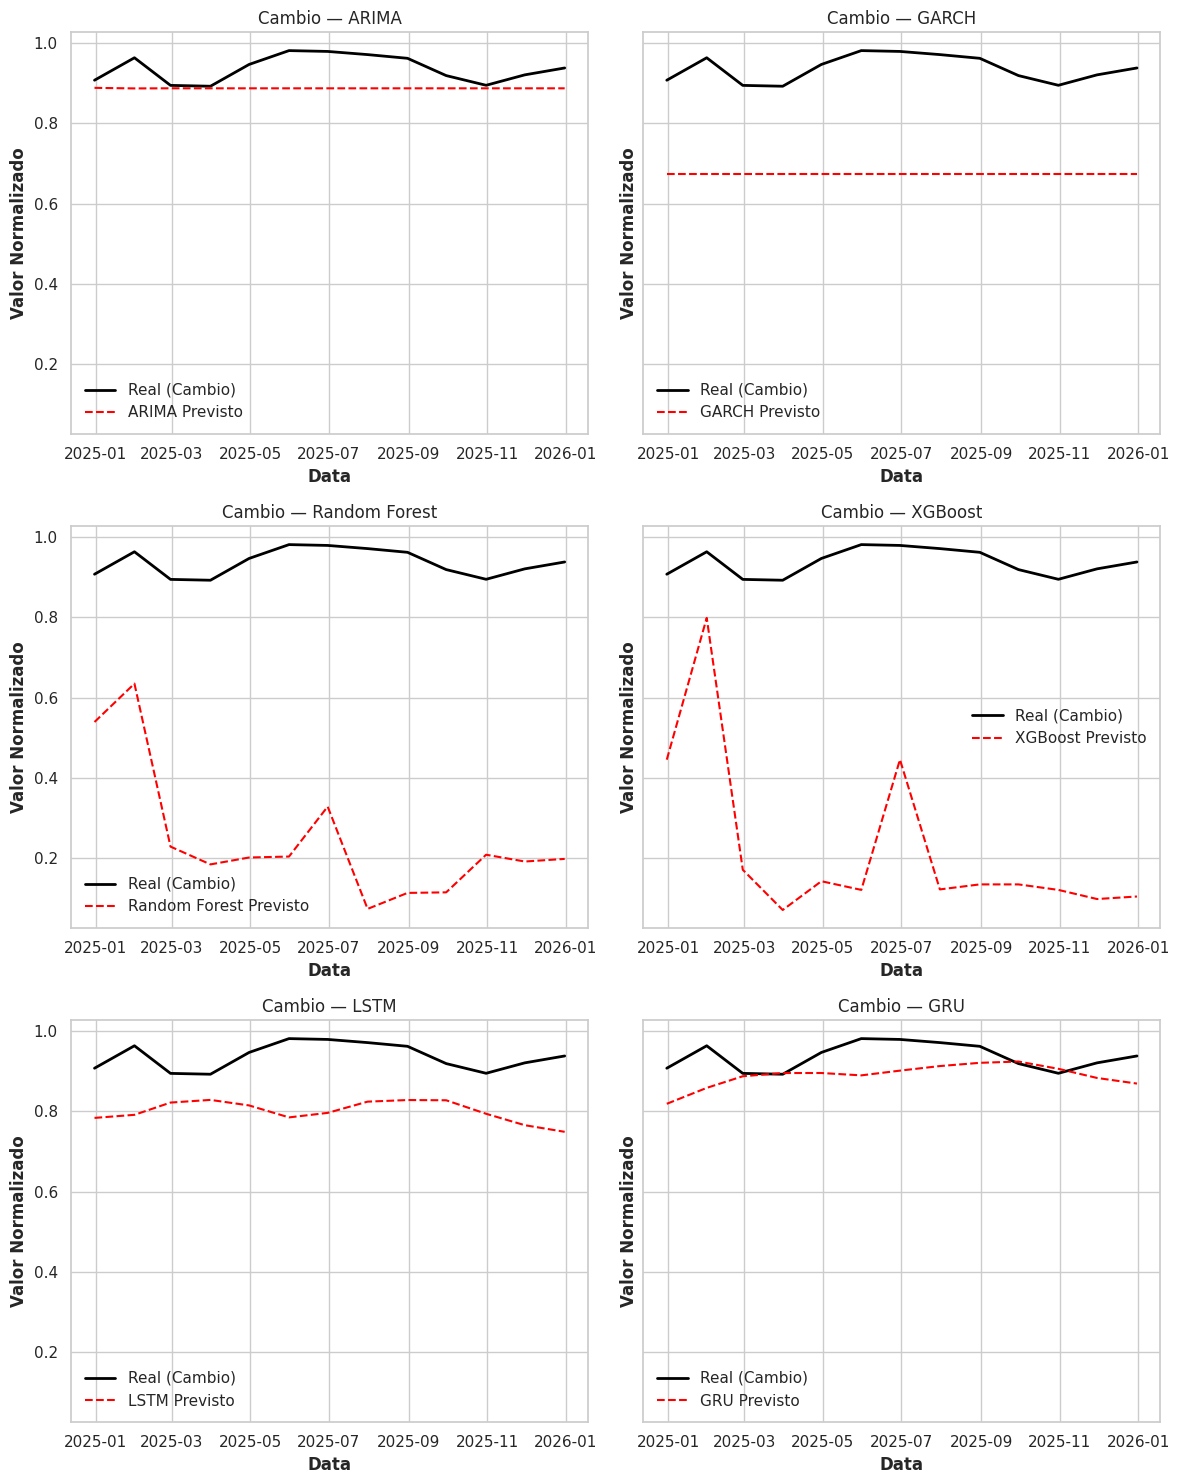

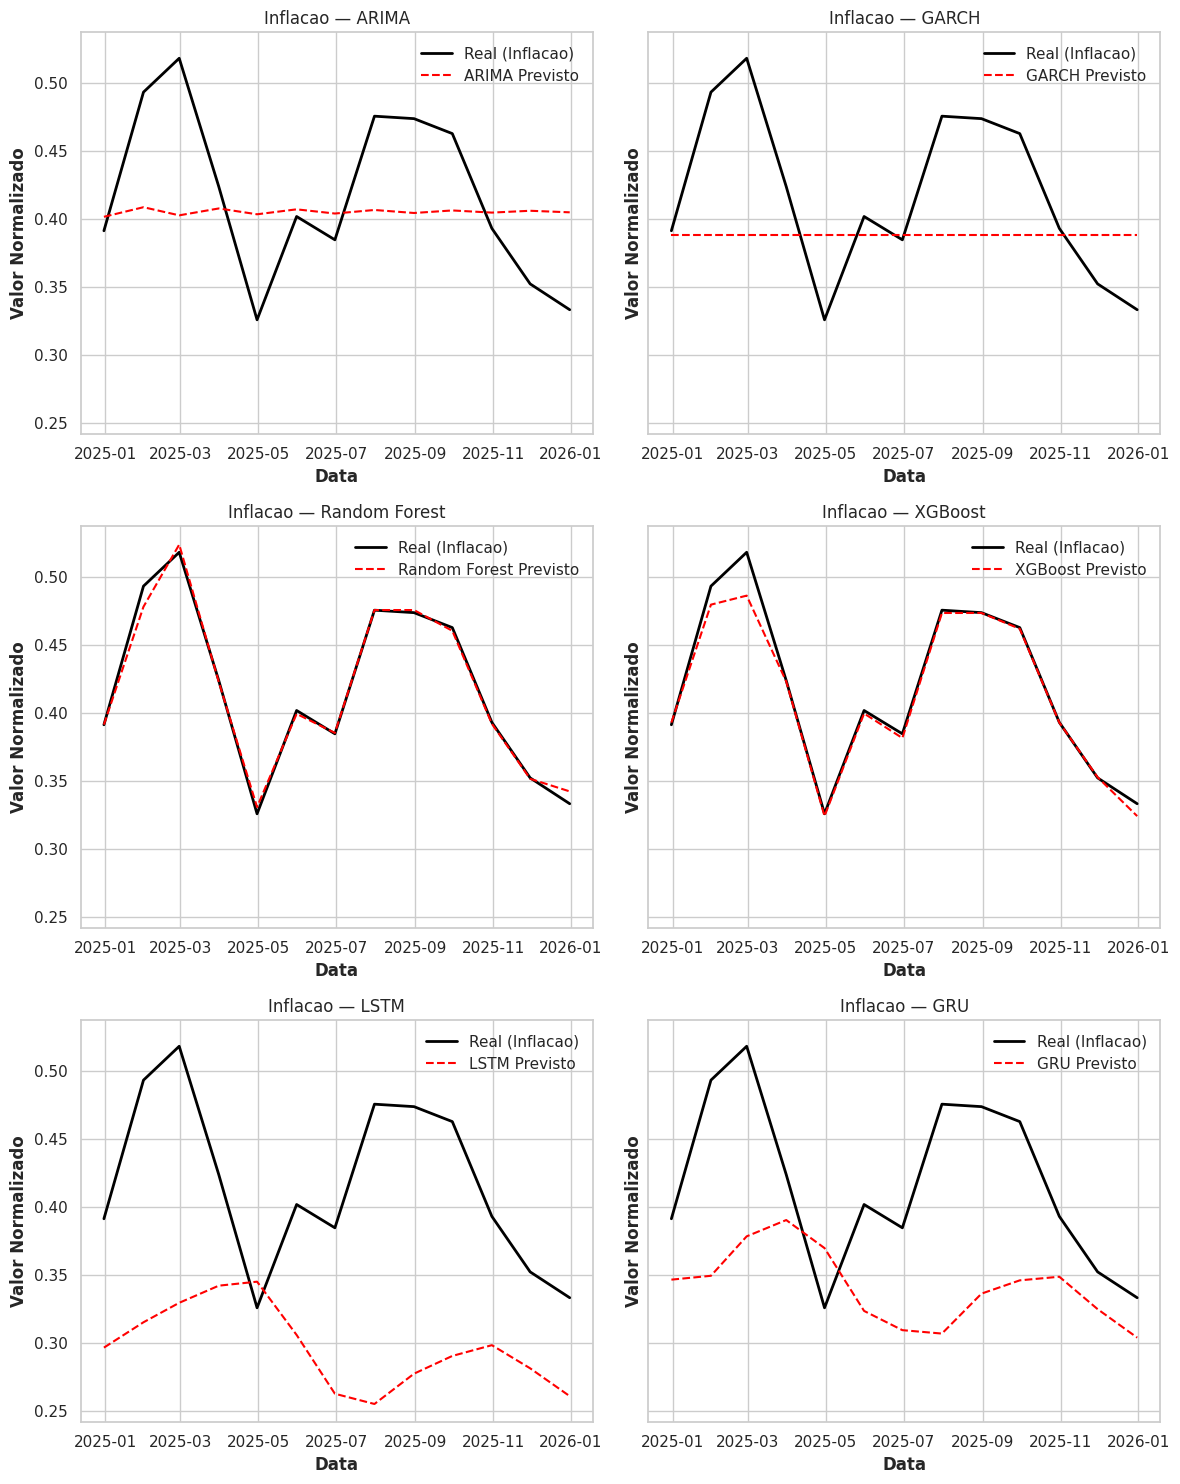

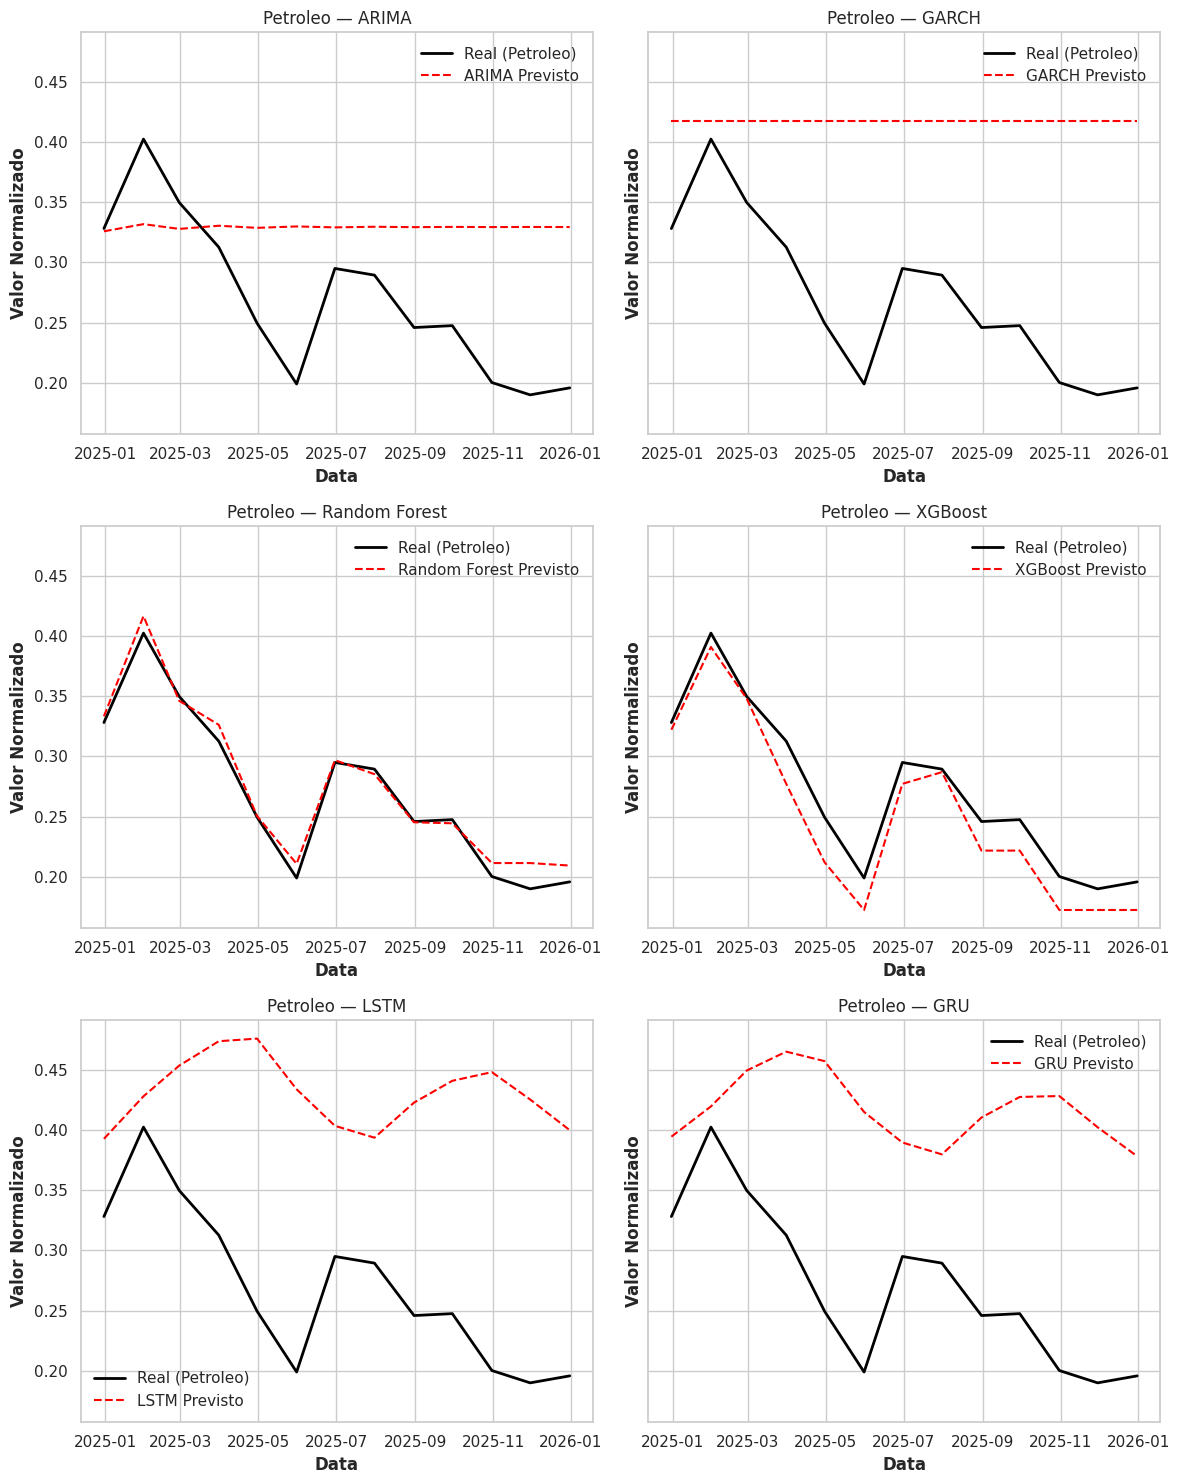

In [12]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Configuração
# ------------------------------------------------------------
targets = list(all_actuals.keys())  # todas as variáveis alvo
models = list(all_predictions[targets[0]].keys())  # todos os modelos disponíveis

# Map de nomes, se necessário
model_name_map = {
    'RF': 'Random Forest',
    'XGB': 'XGBoost',
    'LSTM': 'LSTM',
    'GRU': 'GRU'
}

# ------------------------------------------------------------
# Loop por variável target
# ------------------------------------------------------------
for target_variable in targets:
    actual_values = all_actuals[target_variable]

    n_models = len(models)
    n_rows = (n_models + 1) // 2  # 2 gráficos por linha
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows), sharey=True)
    axes = axes.flatten()  # simplificar indexação

    for i, model_key in enumerate(models):
        model_name = model_name_map.get(model_key, model_key)
        predictions = all_predictions[target_variable][model_key]

        axes[i].plot(actual_values.index, actual_values.values, label=f"Real ({target_variable})", color='black', linewidth=2)
        axes[i].plot(predictions.index, predictions.values, label=f"{model_name} Previsto", color='red', linestyle='--')
        axes[i].set_title(f"{target_variable} — {model_name}")
        axes[i].set_xlabel("Data")
        axes[i].set_ylabel("Valor Normalizado")
        axes[i].legend()
        axes[i].grid(True)

    # Remover eixos extras caso n_models seja ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
